In [1]:
import pandas as pd
import re
import numpy as np
import networkx as nx
# Set pandas option to display all rows
pd.set_option('display.max_rows', None)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.feature_selection import mutual_info_regression
from io import BytesIO
import base64
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import chi2_contingency
from scipy.stats import zscore

In [2]:
df = pd.read_csv('.\\data\\train.csv')
#df = pd.read_csv('.\\data\\train.csv')

In [3]:
df.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000
1,1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,Yes,8250
2,2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000
3,3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500
4,4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850


In [5]:
df.describe(include='all')

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
count,54273.000000,54273,54273,54273.000000,54273.000000,54273,54273,54273,54273,54273,54273,54273,5.427300e+04
unique,NaN,53,1827,NaN,NaN,7,1061,46,260,124,2,1,NaN
top,NaN,BMW,F-150 XLT,NaN,NaN,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,A/T,Black,Black,None reported,Yes,NaN
freq,NaN,7369,780,NaN,NaN,49439,1452,16757,15078,31820,39896,54273,NaN
mean,27136.000000,NaN,NaN,2015.091979,72746.175667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.921844e+04
std,15667.409917,NaN,NaN,5.588909,50469.490448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.282634e+04
min,0.000000,NaN,NaN,1974.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+03
25%,13568.000000,NaN,NaN,2012.000000,32268.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.550000e+04
50%,27136.000000,NaN,NaN,2016.000000,66107.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.800000e+04
75%,40704.000000,NaN,NaN,2019.000000,102000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.500000e+04


In [6]:
df.describe()  # all nuemrical features

,id,model_year,milage,price
count,54273.000000,54273.000000,54273.000000,5.427300e+04
mean,27136.000000,2015.091979,72746.175667,3.921844e+04
std,15667.409917,5.588909,50469.490448,7.282634e+04
min,0.000000,1974.000000,100.000000,2.000000e+03
25%,13568.000000,2012.000000,32268.000000,1.550000e+04
50%,27136.000000,2016.000000,66107.000000,2.800000e+04
75%,40704.000000,2019.000000,102000.000000,4.500000e+04
max,54272.000000,2024.000000,405000.000000,2.954083e+06


## <span style='color: red;'>Mutual Information score</span>

In [5]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [6]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

milage       0.867563
model        0.408834
int_col      0.116095
fuel_type    0.020653
Name: MI Scores, dtype: float64

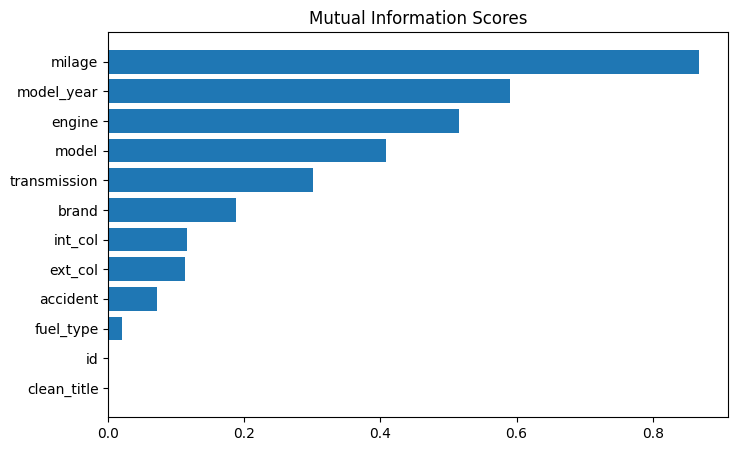

In [7]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

## <span style='color: red;'>Using PEARSON correlation for numerical columns</span>

In [19]:
numeric_features = df.select_dtypes(include=['int64', 'float64'])
# Calculate correlation matrix for categorical columns (if applicable)
if not numeric_features.empty:
  pearson_corr_matrix = numeric_features.corr(method='pearson')  # Spearman for categorical data
  print("Correlation Matrix (numerical features):")
else:
  print("No numerical columns found in the DataFrame for correlation.")
pearson_corr_matrix

Correlation Matrix (numerical features):


,id,model_year,milage,price
id,1.000000,0.000741,-0.003194,0.000587
model_year,0.000741,1.000000,-0.625226,0.216150
milage,-0.003194,-0.625226,1.000000,-0.248927
price,0.000587,0.216150,-0.248927,1.000000


In [ ]:
sns.heatmap(Pearson_corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## <span style='color: red;'>Using SPEARMAN correlation for numerical columns</span>

In [9]:
numeric_features = df.select_dtypes(include=['int64', 'float64'])
# Calculate correlation matrix for categorical columns (if applicable)
if not numeric_features.empty:
  spearman_corr_matrix = numeric_features.corr(method='spearman')  # Spearman for categorical data
  print("Correlation Matrix (numerical features):")
else:
  print("No numerical columns found in the DataFrame for correlation.")
spearman_corr_matrix

Correlation Matrix (numerical features):


,id,model_year,milage,price
id,1.000000,0.001869,-0.004924,0.001475
model_year,0.001869,1.000000,-0.700171,0.721409
milage,-0.004924,-0.700171,1.000000,-0.718992
price,0.001475,0.721409,-0.718992,1.000000


In [ ]:
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## <span style='color: red;'>Plotting both correlation stacked side by side</span> 

C:\Users\PTB3KOR\AppData\Local\Temp\ipykernel_27988\2651173339.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0])
C:\Users\PTB3KOR\AppData\Local\Temp\ipykernel_27988\2651173339.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs[1])


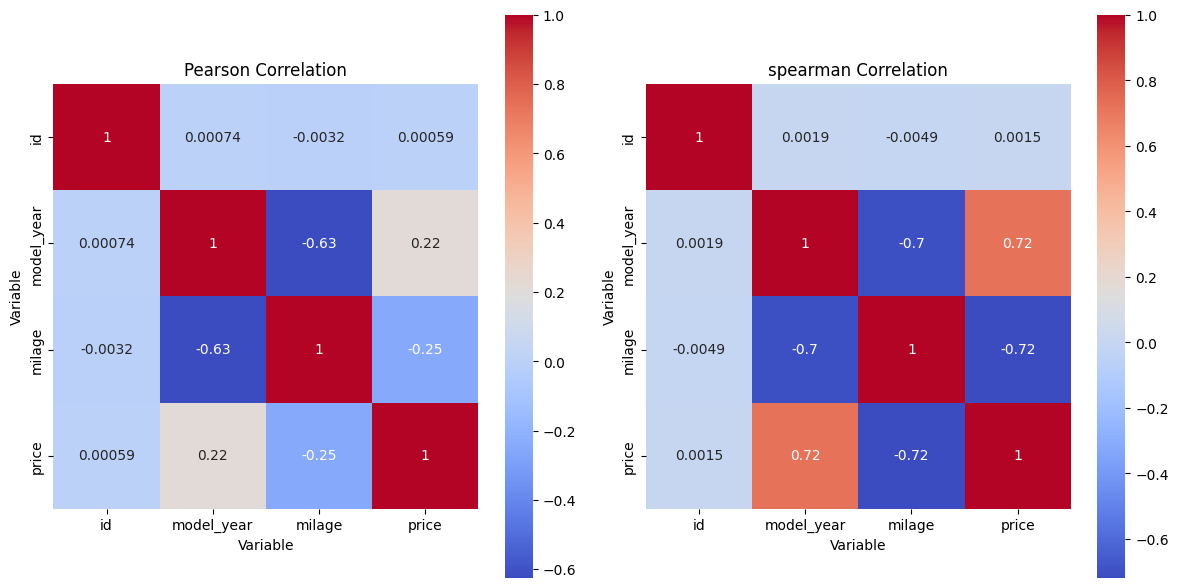

In [25]:
# Assuming you have two correlation matrices (corr1 and corr2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figure size as needed

# Define subplot positions using gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # Adjust width ratios if needed

# Create heatmaps with informative titles and labels
ax1 = plt.subplot(gs[0])
sns.heatmap(pearson_corr_matrix, annot=True, cmap="coolwarm", ax=ax1)
ax1.set_title("Pearson Correlation")
ax1.set_xlabel("Variable")
ax1.set_ylabel("Variable")

ax2 = plt.subplot(gs[1])
sns.heatmap(spearman_corr_matrix, annot=True, cmap="coolwarm", ax=ax2)
ax2.set_title("spearman Correlation")
ax2.set_xlabel("Variable")
ax2.set_ylabel("Variable")

ax1.set_aspect('equal')
ax2.set_aspect('equal')

# Adjust spacing between subplots (optional)
plt.tight_layout()
plt.show()

## <span style='color: red;'>Calculate Z-scores</span> 

In [6]:
# Calculate Z-scores
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))

# Remove outliers (rows where any column has a Z-score greater than 3)
df_no_outliers = df[(z_scores < 3).all(axis=1)]
df_no_outliers.shape

(53005, 13)

## <span style='color: red;'>Combining the IQR and Z-score methods to remove outliers</span> 

In [3]:
# Remove outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for column in df.select_dtypes(include=[np.number]).columns:
    df = remove_outliers_iqr(df, column)

# Remove outliers using Z-score method
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
df = df[(z_scores < 3).all(axis=1)]

# Check the shape of the dataset after removing outliers
df.shape

(49366, 13)

# <span style='color: green;'>BRAND</span>

## Price replot

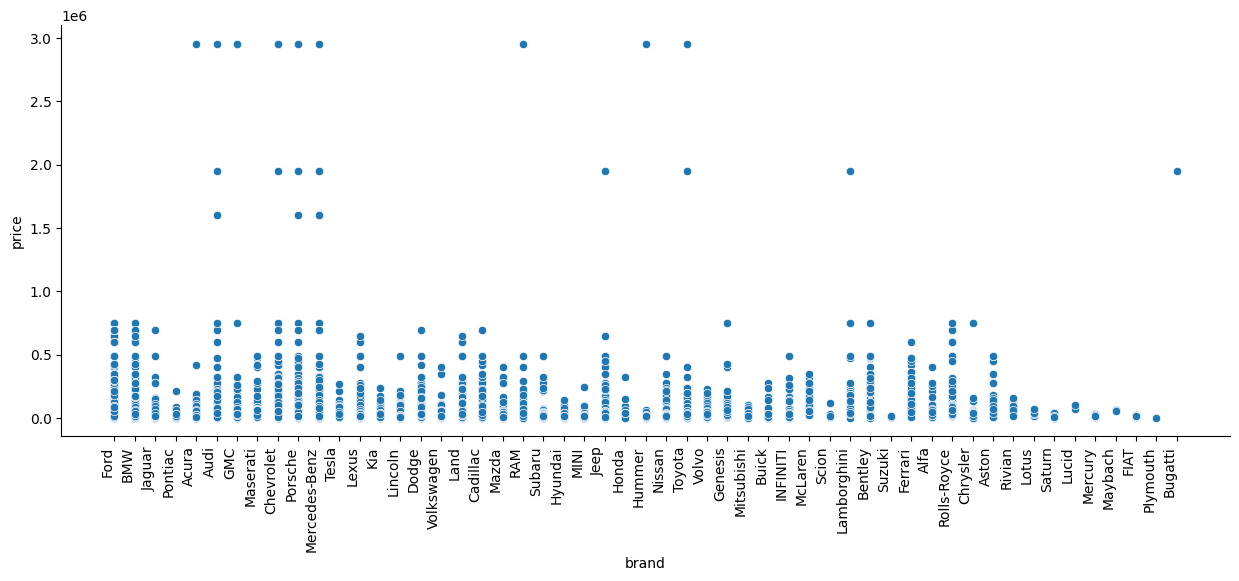

In [13]:
# Set the plot's height and aspect ratio
sns.relplot(x="brand", y="price", data=df, height=5, aspect=2.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot
plt.show()

In [73]:
df[df['price'] > 1.5e6].sort_values('price', ascending=True)

,id,brand,model,model_year,milage,fuel_type,engine_power,engine_volume,engine_cylinder,cylinder_shape,engine,gears,transmission,ext_col,int_col,accident,clean_title,price
2568,2568,Porsche,911 GT3,2019,1568,Gasoline,475.0,3.8,6.0,Flat,NaN,7.0,Automatic,White,Black,0,Yes,1599000
5794,5794,Mercedes-Benz,AMG GT R,2017,3811,Gasoline,577.0,4.0,8.0,NaN,NaN,7.0,Automatic,Gray,Black,0,Yes,1599000
32844,32844,Porsche,Cayenne S,2023,1500,Gasoline,400.0,4.8,8.0,NaN,NaN,8.0,Automatic,Gray,Gray,0,Yes,1599000
49610,49610,Audi,RS 7 4.0T Prestige,2016,64800,Gasoline,560.0,4.0,8.0,NaN,NaN,8.0,Automatic,Gray,Brown,0,Yes,1599000
47387,47387,Audi,RS 7 4.0T Performance Prestige,2020,22000,Gasoline,605.0,4.0,8.0,NaN,NaN,8.0,Automatic,Blue,White,0,Yes,1599000
13284,13284,Mercedes-Benz,AMG G 63 Base,2022,2950,Gasoline,577.0,4.0,8.0,NaN,NaN,Value Missing,Automatic,White,Black,0,Yes,1599000
13385,13385,Mercedes-Benz,AMG GLE AMG GLE 63 S-Model 4MATIC,2018,2800,Gasoline,577.0,5.5,8.0,NaN,NaN,7.0,Automatic,White,Black,0,Yes,1599000
38273,38273,Porsche,911 Carrera S,2015,28470,Gasoline,385.0,3.8,6.0,Flat,NaN,6.0,other,Gray,Black,0,Yes,1599000
37520,37520,Audi,R8 5.2 V10 performance,2011,12245,Gasoline,NaN,5.2,10.0,V,GDI DOHC,7.0,Automatic,White,White,0,Yes,1950995
26175,26175,Chevrolet,Monte Carlo SS,2007,79000,Gasoline,200.0,3.8,6.0,V,NaN,4.0,Automatic,Red,Black,0,Yes,1950995


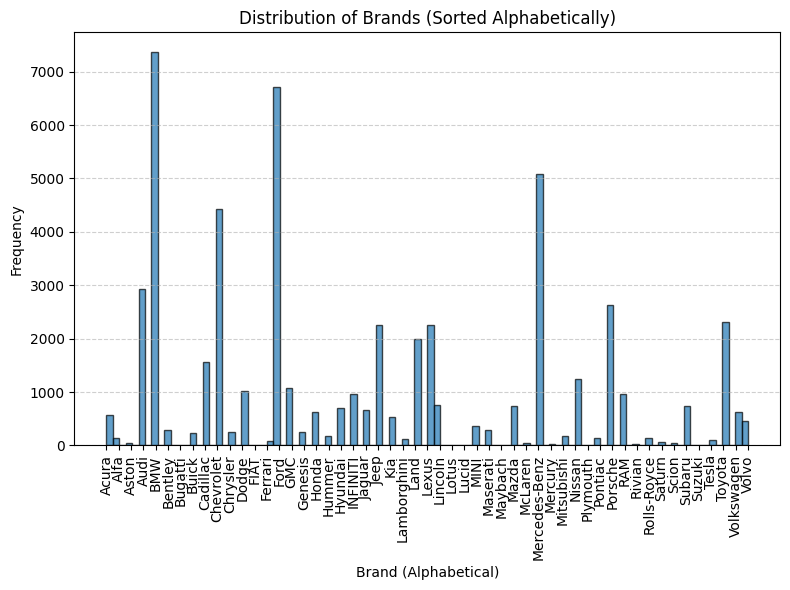

In [86]:
# Assuming 'brand' is the column containing brand names in your DataFrame (replace if necessary)
brands = df['brand'].sort_values().to_list()  # Sort brands alphabetically

# Create the histogram with informative labels and title
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.hist(brands, bins=100, edgecolor='black', alpha=0.7)  # Adjust bin count and transparency
plt.xlabel('Brand (Alphabetical)')
plt.ylabel('Frequency')
plt.title('Distribution of Brands (Sorted Alphabetically)')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=90)

# Customize the plot (optional)
plt.grid(axis='y', linestyle='--', alpha=0.6)  # Add grid lines with dashed style and adjusted transparency
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()


In [127]:
from sklearn.feature_selection import mutual_info_regression
# Calculate mutual information for categorical variables
def calculate_mutual_info(df, target):
    categorical_columns = ['brand']
    mi = mutual_info_regression(pd.get_dummies(df[categorical_columns]), df[target])
    mi_series = pd.Series(mi, index=pd.get_dummies(df[categorical_columns]).columns)
    return mi_series

mi_scores = calculate_mutual_info(df, 'price')
mi_score = mi_scores.sum()
mi_score

0.22602857678945698

# <span style='color: green;'>MODEL</span>

In [124]:
# Step 1: Extract unique words from the 'model' column
unique_words = df['model'].unique()

# Step 2: Create a graph using networkx
G = nx.Graph()

# Add nodes for brands
brands = 'Acura'
G.add_nodes_from(brands, bipartite=0)

# Add nodes for unique words
G.add_nodes_from(unique_words, bipartite=1)

# Add edges between brands and associated unique words
for brand in brands:
    models = df[df['brand'] == brand]['model'].unique()
    for model in models:
        G.add_edge(brand, model)

# Step 3: Plot the graph
plt.figure(figsize=(100, 100))
pos = nx.spring_layout(G, k=0.5)  # Position nodes using a spring layout
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, font_weight='bold', edge_color='gray', linewidths=1, alpha=0.8)

plt.title('Brand-Model Connections', fontsize=15)

# Save the plot to a BytesIO object
buf = BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
plt.close()

# Generate HTML to display the image in a new tab with zoom functionality
html_content = f'''
<!DOCTYPE html>
<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1.0">
<style>
img {{
  width: 100%;
  height: auto;
}}
</style>
</head>
<body>
<img src="data:image/png;base64,{image_base64}">
</body>
</html>
'''

# Write HTML content to a file (or display in a web browser)
with open('brand_model_graph.html', 'w') as f:
    f.write(html_content)

# Open the HTML file in a web browser (optional)
import webbrowser
webbrowser.open('brand_model_graph.html')

True

In [51]:
df['model'].nunique()

1827

In [72]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Group by 'brand' and aggregate 'model' and 'price'
grouped_df = df.groupby('brand').agg({
    'model': lambda x: ', '.join(x.unique()),
    'price': ['mean', 'std', 'max'] , # Include standard deviation
    'brand': 'count'
}).reset_index()

# Adjust column names
grouped_df.columns = ['brand', 'models', 'average_price', 'price_std', 'max', 'counts']

# Sort by 'average_price' in ascending order
grouped_df_sorted = grouped_df.sort_values(by='max', ascending=True)

# Display the grouped DataFrame
grouped_df_sorted


,brand,models,average_price,price_std,max,counts
39,Plymouth,Prowler Base,3.850000e+03,NaN,3850,1
48,Suzuki,SX4 Base,1.109975e+04,5093.433706,17900,4
12,FIAT,"500 Sport, 124 Spider Abarth, 500 Lounge, 500X Trekking Plus, 500e Battery Electric",1.418388e+04,3756.430644,20000,16
36,Mercury,"Marauder Base, Capri XR2",1.456180e+04,7000.544231,30000,20
45,Saturn,"Sky Base, Sky Red Line, Vue Hybrid Base",1.373340e+04,10067.528631,42000,58
32,Maybach,Type 57 Base,6.033333e+04,6783.865663,64250,3
28,Lotus,"Evora 400 Base, Evora Base, Elise Base, Evora 2+2",3.845658e+04,20927.569422,69250,12
37,Mitsubishi,"Lancer GTS, Eclipse GT, Lancer Evolution GSR, Eclipse Spyder GT, Lancer DE, Eclipse Spyder GS, Accord EX-L, Eclipse GS, Outlander SEL, Lancer Evolution MR, Lancer Evolution Base, Montero Limited, Element EX, Lancer Evolution IX, Lancer Sportback ES, Outlander Sport ES, Mirage ES, Outlander Sport 2.4 SE",1.343454e+04,12365.992384,98900,182
29,Lucid,Air Grand Touring,8.418500e+04,22295.076811,99950,2
46,Scion,"xB Base, tC Release Series 6.0, FR-S Monogram, tC Anniversary Edition, tC Base, Corolla LE",1.293953e+04,15735.017780,119900,53


In [128]:
from sklearn.feature_selection import mutual_info_regression
# Calculate mutual information for categorical variables
def calculate_mutual_info(df, target):
    categorical_columns = ['model']
    mi = mutual_info_regression(pd.get_dummies(df[categorical_columns]), df[target])
    mi_series = pd.Series(mi, index=pd.get_dummies(df[categorical_columns]).columns)
    return mi_series

mi_scores = calculate_mutual_info(df, 'price')
mi_score = mi_scores.sum()
mi_score

2.6715328342409754

# <span style='color: green;'>MODEL_YEAR</span>

In [125]:
df['model_year'].value_counts()

model_year
2018    4888
2016    4693
2017    4042
2019    4014
2020    4012
2021    3781
2015    3715
2022    3140
2014    2941
2013    2452
2011    2106
2012    2101
2023    1794
2008    1741
2007    1584
2010    1508
2009     983
2005     967
2006     865
2004     745
2003     557
2001     461
2002     391
1999     176
2000     152
1998     117
1997      80
1996      76
1995      48
1993      47
2024      42
1994      37
1992      12
1974       5
Name: count, dtype: int64

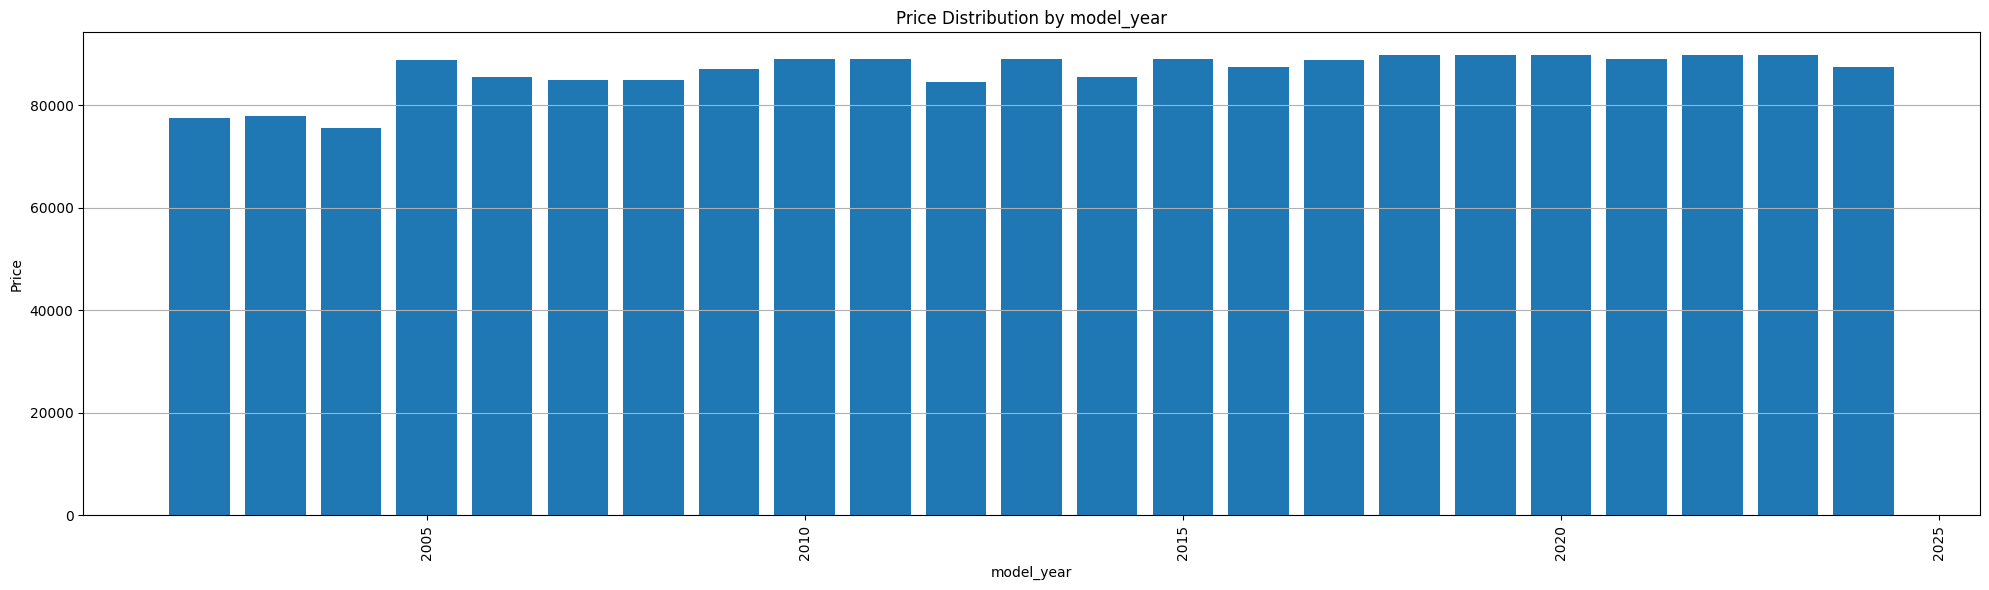

In [14]:
plt.figure(figsize=(20, 6))  # Adjust figure size as needed 
plt.bar(df['model_year'], df['price'])  # X-axis: int_col, Y-axis: price
plt.xlabel('model_year')
plt.ylabel('Price')
plt.title('Price Distribution by model_year')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability

# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

In [107]:
# Features and target variable
X = df[['model_year']]
y = df['price']

# Calculate mutual information
mi_scores = mutual_info_regression(X, y)
mi_scores 

array([0.58984723])

# <span style='color: green;'>MILAGE</span>

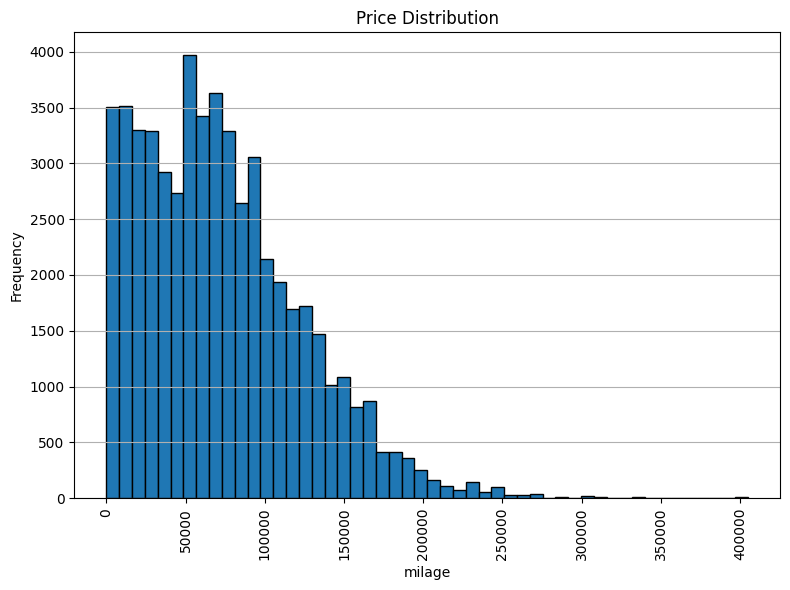

In [13]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed 
plt.hist(df['milage'], bins=50, edgecolor='black')
plt.xlabel('milage')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability
# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

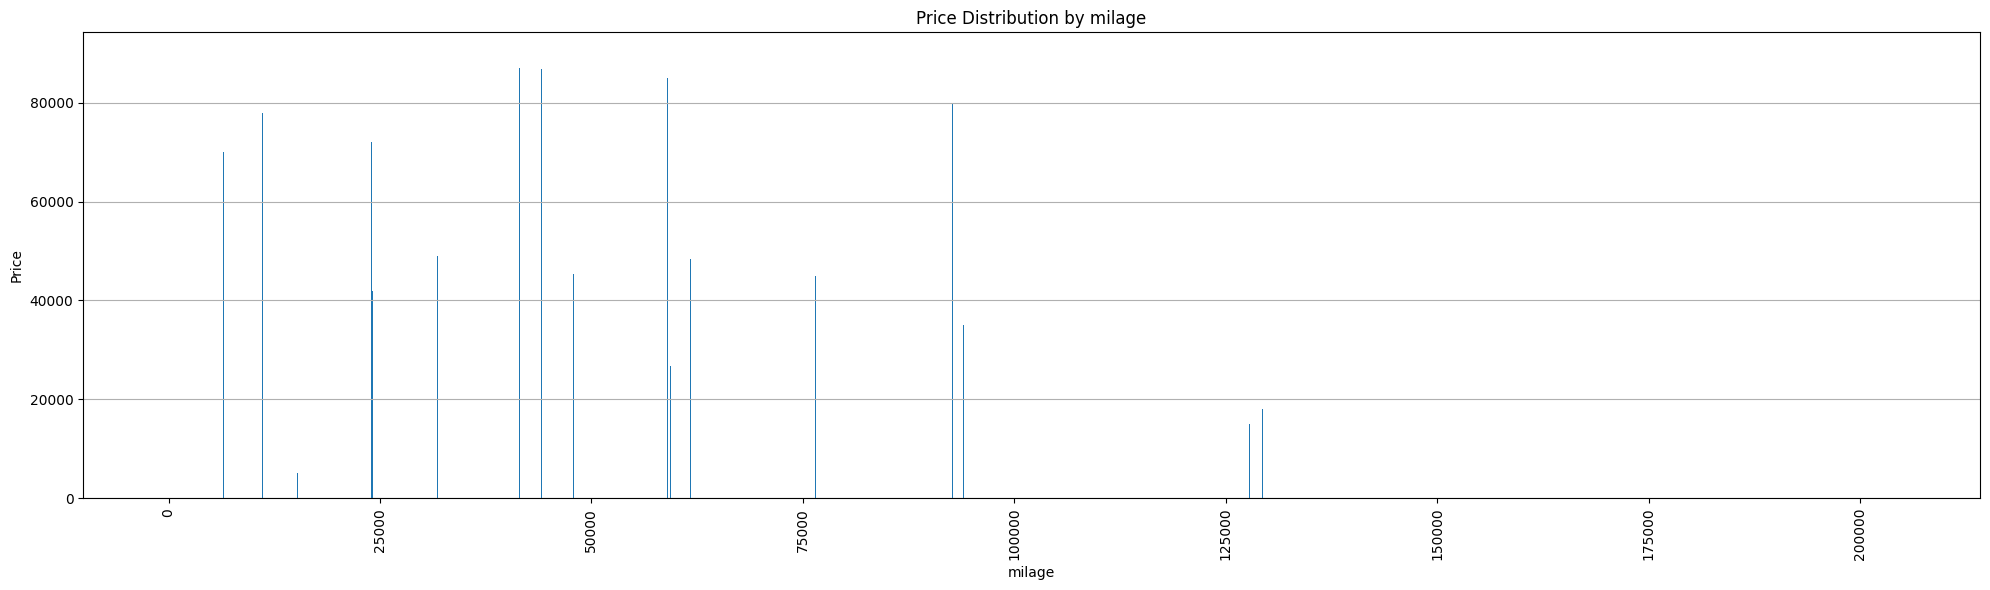

In [15]:
plt.figure(figsize=(20, 6))  # Adjust figure size as needed 
plt.bar(df['milage'], df['price'])  # X-axis: int_col, Y-axis: price
plt.xlabel('milage')
plt.ylabel('Price')
plt.title('Price Distribution by milage')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability

# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

In [108]:
# Features and target variable
X = df[['milage']]
y = df['price']

# Calculate mutual information
mi_scores = mutual_info_regression(X, y)
mi_scores 

array([0.86952268])

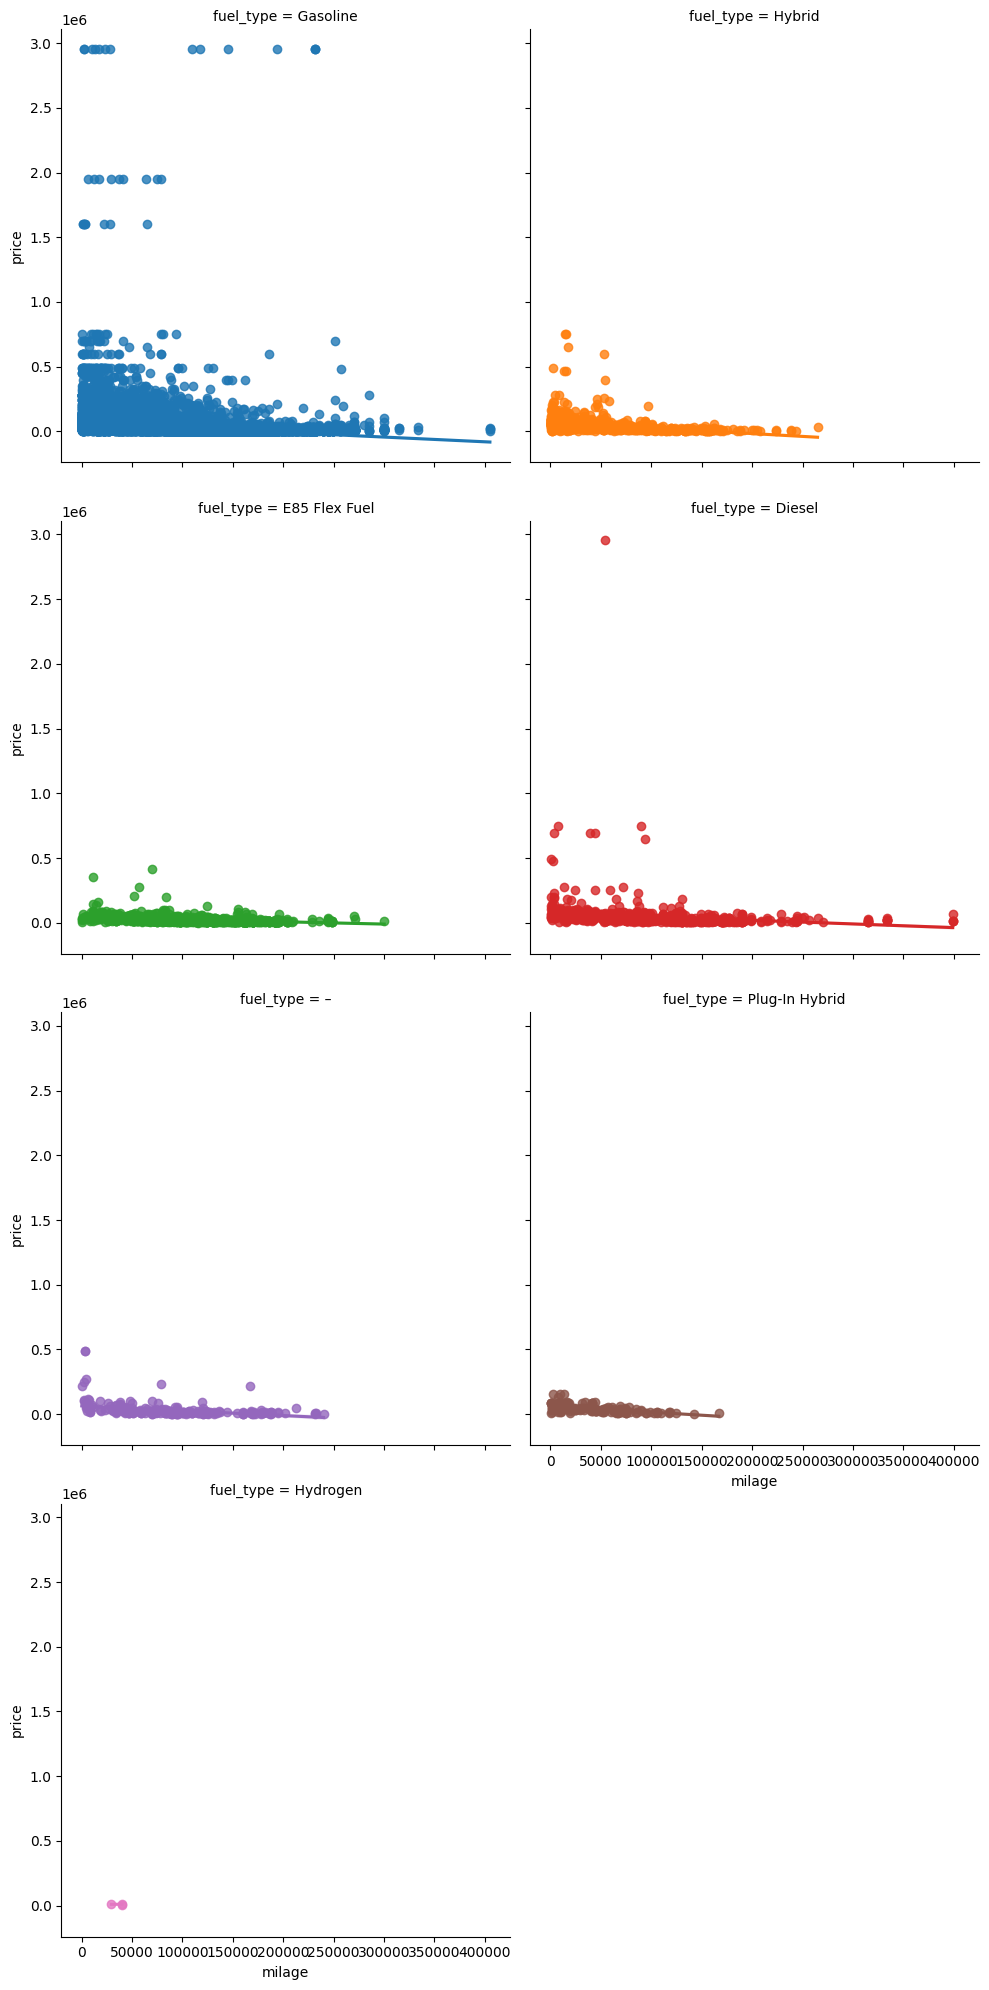

In [134]:
sns.lmplot(x="milage", y="price", hue="fuel_type", data=df, col="fuel_type", col_wrap=2)

In [ ]:
# Create a pairplot
pairplot = sns.pairplot(df, hue="fuel_type")

# Save the pairplot to a figure
pairplot.fig.savefig("pairplot.png")

# Load the saved figure
fig, ax = plt.subplots(2, 8, figsize=(20, 10))

# Remove axes for unused subplots
for i in range(2):
    for j in range(8):
        ax[i, j].axis('off')

# Manually add the pairplot to the first subplot
img = plt.imread("pairplot.png")
ax[0, 0].imshow(img)
ax[0, 0].axis('off')  # Turn off the axis

plt.tight_layout()
plt.show()

# Correlation matrix for numerical columns with price

In [39]:
# Select non-numerical columns (categorical in this case)
categorical_cols = df.select_dtypes(include=['object', 'category'])
numeric_features = df.select_dtypes(include=['int64', 'float64'])
# Calculate correlation matrix for categorical columns (if applicable)
if not numeric_features.empty:
  corr_matrix = numeric_features.corr(method='spearman')  # Spearman for categorical data
  print("Correlation Matrix (numerical features):")
else:
  print("No numerical columns found in the DataFrame for correlation.")
corr_matrix

Correlation Matrix (numerical features):


,id,model_year,milage,price
id,1.000000,0.001869,-0.004924,0.001475
model_year,0.001869,1.000000,-0.700171,0.721409
milage,-0.004924,-0.700171,1.000000,-0.718992
price,0.001475,0.721409,-0.718992,1.000000


# Correlation matrix for categorical columns with price

In [70]:
# Define the function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# List of categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.append('price')
# Initialize an empty DataFrame for the correlation matrix
corr_matrix = pd.DataFrame(np.zeros((len(categorical_columns), len(categorical_columns))), 
                           index=categorical_columns, 
                           columns=categorical_columns)

# Compute Cramér's V for each pair of categorical columns
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0
        else:
            corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

corr_matrix

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,price
brand,1.000000,0.961178,0.177546,0.802418,0.233543,0.183672,0.165746,0.165559,0.138356
model,0.961178,1.000000,0.778347,0.696765,0.558648,0.356037,0.377120,0.369239,0.112550
fuel_type,0.177546,0.778347,1.000000,0.931695,0.075607,0.030944,0.059566,0.061513,0.080503
engine,0.802418,0.696765,0.931695,1.000000,0.438220,0.298174,0.347549,0.346173,0.116204
transmission,0.233543,0.558648,0.075607,0.438220,1.000000,0.182975,0.101625,0.045325,0.178748
ext_col,0.183672,0.356037,0.030944,0.298174,0.182975,1.000000,0.474042,0.100327,0.281773
int_col,0.165746,0.377120,0.059566,0.347549,0.101625,0.474042,1.000000,0.132549,0.264371
accident,0.165559,0.369239,0.061513,0.346173,0.045325,0.100327,0.132549,1.000000,0.352725
price,0.138356,0.112550,0.080503,0.116204,0.178748,0.281773,0.264371,0.352725,1.000000


# <span style='color: green;'>FUEL TYPE</span>

## Data cleaning for column: fuel_type

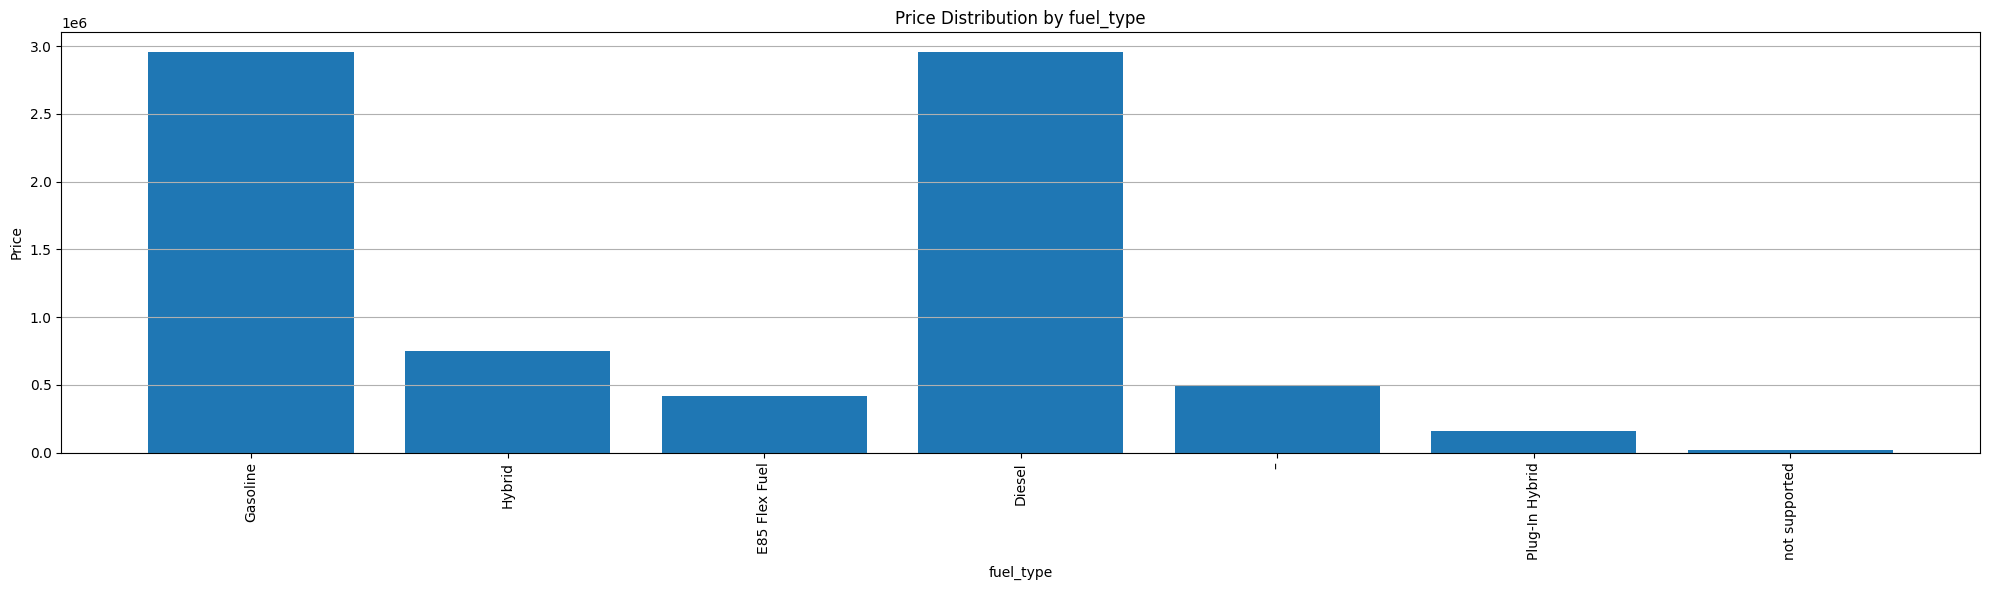

In [101]:
plt.figure(figsize=(20, 6))  # Adjust figure size as needed 
plt.bar(df['fuel_type'], df['price'])  # X-axis: int_col, Y-axis: price
plt.xlabel('fuel_type')
plt.ylabel('Price')
plt.title('Price Distribution by fuel_type')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability

# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

In [3]:
df['fuel_type'].value_counts()

fuel_type
Gasoline          49439
Hybrid             1766
E85 Flex Fuel      1479
Diesel             1109
–                   294
Plug-In Hybrid      182
not supported         4
Name: count, dtype: int64

## Data cleaning for column: fuel_type

In [4]:
def replace_fuel(row):
    if row['fuel_type'] == 'not supported':
        match = re.search(r'(\b\w+ Fuel\b)', row['engine'])
        if match:
            fuel_type = match.group(1).split()[0]
            return fuel_type
    elif row['fuel_type'] == '–':
        return np.nan
    return row['fuel_type']

# Apply the function to the 'Fuel' column
df['fuel_type'] = df.apply(replace_fuel, axis=1)

In [5]:
df['fuel_type'].value_counts()

fuel_type
Gasoline          49440
Hybrid             1766
E85 Flex Fuel      1479
Diesel             1109
Plug-In Hybrid      182
Hydrogen              3
Name: count, dtype: int64

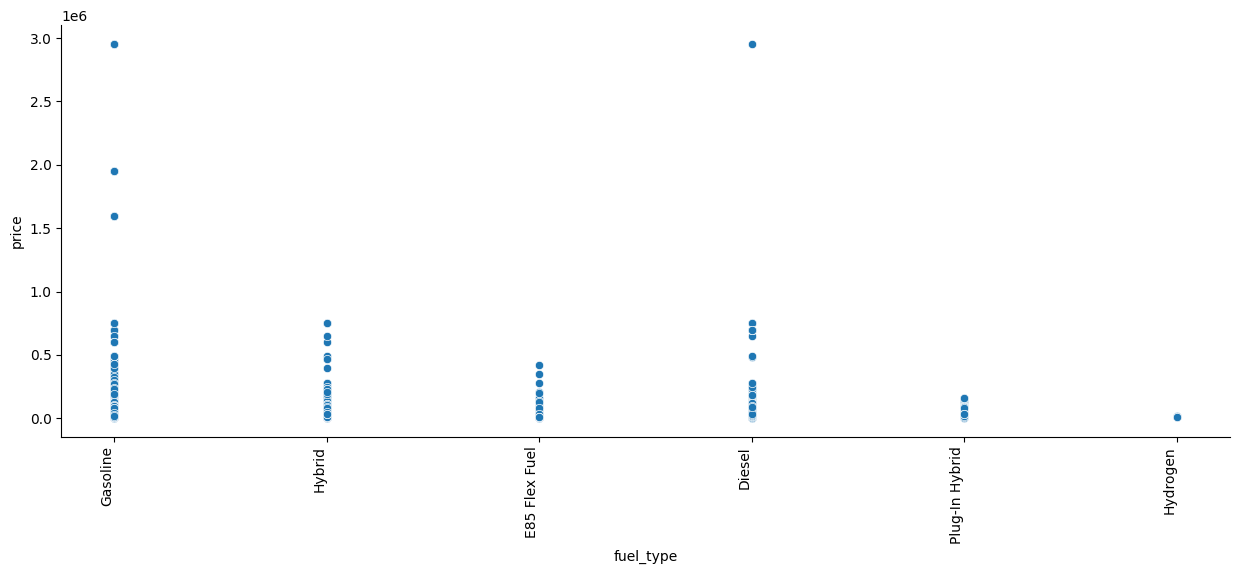

In [27]:
# Set the plot's height and aspect ratio
sns.relplot(x="fuel_type", y="price", data=df, height=5, aspect=2.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot
plt.show()

In [111]:
from sklearn.feature_selection import mutual_info_regression
# Calculate mutual information for categorical variables
def calculate_mutual_info(df, target):
    categorical_columns = ['fuel_type']
    mi = mutual_info_regression(pd.get_dummies(df[categorical_columns]), df[target])
    mi_series = pd.Series(mi, index=pd.get_dummies(df[categorical_columns]).columns)
    return mi_series

mi_scores = calculate_mutual_info(df, 'price')
mi_score = mi_scores.sum()
mi_score

0.039173058602238076

# <span style='color: green;'>ENGINE</span>

In [ ]:
df['engine'].value_counts()

## Data cleaning for column: engine

In [5]:
# Replace 'engine gasoline fuel' with an empty string
df['engine'] = df['engine'].str.replace('Engine Gasoline Fuel', '', regex=False, case=False).str.strip()
df['engine'] = df['engine'].str.replace('Engine Flex Fuel Capability', '', regex=False, case=False).str.strip() 
df['engine'] = df['engine'].str.replace('Engine Diesel Fuel', '', regex=False, case=False).str.strip() 
# Replace ' Liter' with 'L' and join with the previous string
df['engine'] = df['engine'].str.replace(r'(\d\.\d) Liter', r'\1L', regex=True)

In [6]:
# Extract engine_power
df['engine_power'] = df['engine'].str.extract(r'(\d+\.\d+HP|\d+HP)', expand=False)
# Extract engine_volume
df['engine_volume'] = df['engine'].str.extract(r'(\d+\.\d+L|\d+L)', expand=False)

In [7]:
# Handle special case for entries like "6.7 L/406"
special_pattern = re.compile(r'(\d+\.\d+\s*L/\d+)')
special_volumes = df['engine'].str.extract(special_pattern, expand=False)
df['engine_volume'] = df['engine_volume'].fillna(special_volumes.str.extract(r'(\d+\.\d+\s*L)', expand=False))

In [8]:
# Remove extracted parts from engine column
df['engine'] = df['engine'].str.replace(r'(\d+\.\d+HP|\d+HP)', '', regex=True)
df['engine'] = df['engine'].str.replace(r'(\d+\.\d+L|\d+L)', '', regex=True)
df['engine'] = df['engine'].str.replace(special_pattern, '', regex=True)

# Clean up extra spaces
df['engine'] = df['engine'].str.strip()

In [9]:
df[['engine_power', 'engine_volume', 'engine']].head()

,engine_power,engine_volume,engine
0,375.0HP,3.5L,V6 Cylinder
1,300.0HP,3.0L,Straight 6 Cylinder
2,300.0HP,4.2L,8 Cylinder
3,335.0HP,3.0L,Straight 6 Cylinder Engine Gasoline/Mild Elect...
5,140.0HP,1.8L,4 Cylinder


In [10]:
# Define a function to extract the cylinder part and update the engine column
def extract_engine_cylinder(engine_str):
    if pd.isna(engine_str):
        return np.nan, engine_str
    
    # Regular expression to find strings that start with a letter followed by a number
    match = re.match(r'^([A-Za-z]\d+)', engine_str)
    if match:
        engine_cylinder = match.group(1)
        new_engine_str = engine_str[len(engine_cylinder):].strip()
        return engine_cylinder, new_engine_str
    else:
        return np.nan, engine_str

# Apply the function to the 'engine' column using .loc to avoid the warning
df['engine_cylinder'], df['engine'] = zip(*df['engine'].apply(extract_engine_cylinder))

In [11]:
'''
The function attempts to extract the number of cylinders from the 'engine' column value  and populate the missing values in 'engine_cylinder' if possible. 
It also updates the 'engine' column value to remove the extracted cylinder count.
 '''
def update_engine_cylinder(row):
    if pd.isna(row['engine_cylinder']):
        engine_str = str(row['engine'])  # Convert to string to avoid errors
        match = re.search(r'(\d+)\s+Cylinder', engine_str)
        if match:
            row['engine_cylinder'] = int(match.group(1))
            row['engine'] = re.sub(r'\d+\s+Cylinder', 'Cylinder', engine_str)
    return row

# Apply the function to each row
df = df.apply(update_engine_cylinder, axis=1)

In [12]:
def clean_string(s):
    if isinstance(s, str):  # Check if s is a string
        s = s.replace('PDI', 'GDI')  # Replace 'PDI' with 'GDI'
        s = re.sub(r'\d+V ', '', s)  # Remove digits followed by 'V' and the trailing space
    return s

# Apply the function to the DataFrame column
df['engine'] = df['engine'].apply(clean_string)

In [13]:
df[['engine_power', 'engine_volume', 'engine_cylinder' ,'engine']].head()

,engine_power,engine_volume,engine_cylinder,engine
0,375.0HP,3.5L,V6,Cylinder
1,300.0HP,3.0L,6,Straight Cylinder
2,300.0HP,4.2L,8,Cylinder
3,335.0HP,3.0L,6,Straight Cylinder Engine Gasoline/Mild Electri...
5,140.0HP,1.8L,4,Cylinder


In [14]:
df[['engine_power', 'engine_volume', 'engine_cylinder' ,'engine']].isnull().sum()

engine_power       3473
engine_volume       296
engine_cylinder     391
engine                0
dtype: int64

In [15]:
# Function to update the 'engine' and 'cylinder_shape' columns
def update_engine_cylinder(row):
    # Initialize cylinder_shape
    row['cylinder_shape'] = ''

    # Handle the engine_cylinder column
    if pd.notna(row['engine_cylinder']):
        # Extract letters and digits
        match = re.match(r'([A-Za-z]*)(\d+)', str(row['engine_cylinder']))
        if match:
            letters = match.group(1)
            digits = match.group(2)
            
            # Update the 'cylinder_shape' column with the letters
            row['cylinder_shape'] = letters
            
            # Update the 'engine_cylinder' column with the digits
            row['engine_cylinder'] = digits

    # Handle the engine column for 'straight' and 'flat'
    if pd.notna(row['engine']):
        engine_lower = row['engine'].lower()
        if 'straight' in engine_lower:
            row['cylinder_shape'] = 'Straight'
            row['engine'] = re.sub(r'straight', '', row['engine'], flags=re.IGNORECASE).strip()
        elif 'flat' in engine_lower:
            row['cylinder_shape'] = 'Flat'
            row['engine'] = re.sub(r'flat', '', row['engine'], flags=re.IGNORECASE).strip()

    return row

# Apply the function to each row
df = df.apply(update_engine_cylinder, axis=1)

In [16]:
df[['engine_power', 'engine_volume', 'engine_cylinder' ,'cylinder_shape', 'engine']].isnull().sum()

engine_power       3473
engine_volume       296
engine_cylinder     391
cylinder_shape        0
engine                0
dtype: int64

In [17]:
df['engine'] = df['engine'].str.replace('Gasoline', 'Gas', regex=False, case=False)
df['engine'] = df['engine'].str.replace('Cylinder ', '', regex=False, case=False)
df['engine'] = df['engine'].str.replace('Cylinder', '', regex=False, case=False)
df['engine'] = df['engine'].str.replace('16V', '', regex=False, case=False)
df['engine'] = df['engine'].str.replace('Engine ', '', regex=False, case=False)
df['engine'] = df['engine'].str.replace('–', '', regex=False, case=False)
df['engine'] = df['engine'].str.replace('120 AH', '', regex=False, case=False)
df['engine'] = df['engine'].str.replace(' Flexible Fuel', '', regex=False, case=False)
df['engine'] = df['engine'].str.replace(' Hydrogen Fuel', '', regex=False, case=False)
#df['engine'] = df['engine'].str.replace('Twin', '', regex=False, case=False)
#df['fuel_type'] = df['fuel_type'].str.replace('–', '', regex=False, case=False)

In [18]:
df['engine_power'] = df['engine_power'].str.replace('HP', '', regex=True).astype(float)
df['engine_volume'] = df['engine_volume'].str.replace('L', '', regex=True).astype(float)

In [19]:
#'''
new_order = ['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 
             'engine_power', 'engine_volume', 'engine_cylinder', 'cylinder_shape', 'engine',
             'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'price']
'''

new_order = ['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 
             'engine_power', 'engine_volume', 'engine_cylinder', 'cylinder_shape',
             'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
'''
df = df[new_order]  # Rearrange columns based on the new order

In [20]:
df.isnull().sum()

id                    0
brand                 0
model                 0
model_year            0
milage                0
fuel_type           121
engine_power       3473
engine_volume       296
engine_cylinder     391
cylinder_shape        0
engine                0
transmission          0
ext_col               0
int_col               0
accident              0
clean_title           0
price                 0
dtype: int64

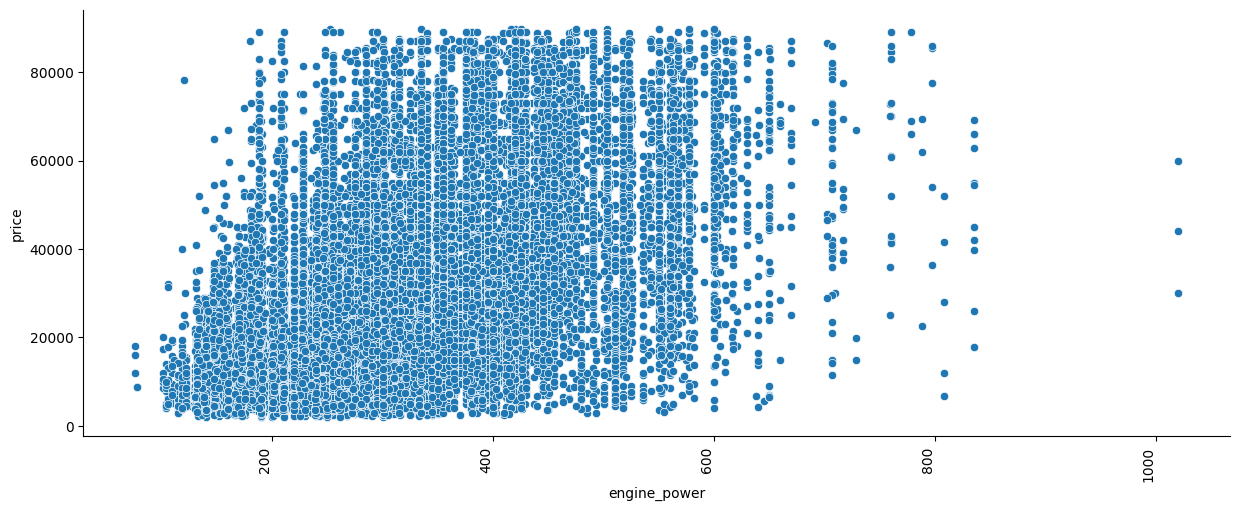

In [21]:
# Set the plot's height and aspect ratio
sns.relplot(x="engine_power", y="price", data=df, height=5, aspect=2.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot
plt.show()

In [22]:
df['engine_power'].replace('Value Missing', np.nan, inplace=True)
df['engine_power'] = df['engine_power'].astype(float)
df['engine_power'].mean()

327.48937746497285

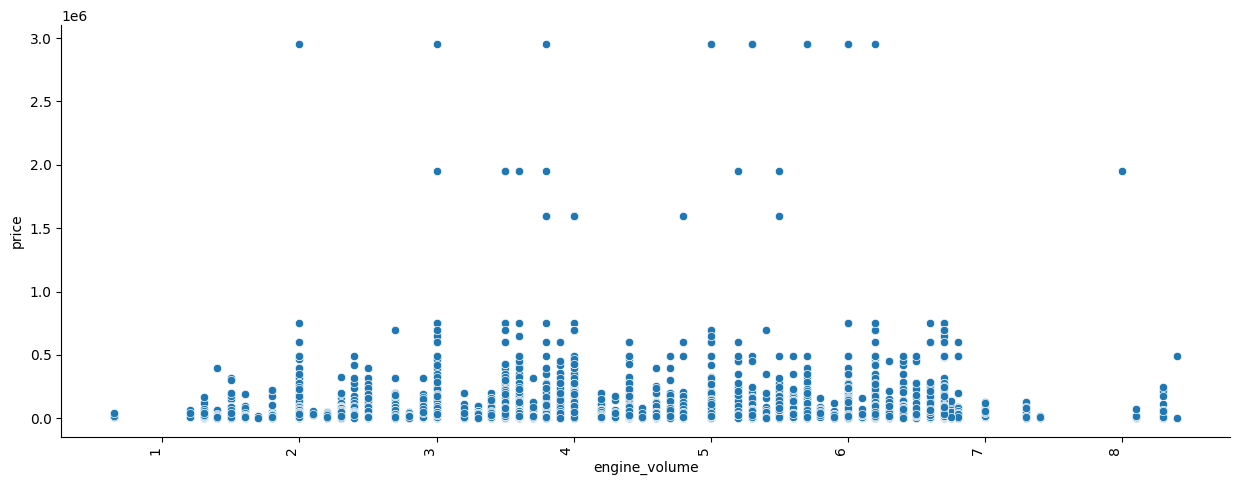

In [28]:
# Set the plot's height and aspect ratio
sns.relplot(x="engine_volume", y="price", data=df, height=5, aspect=2.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot
plt.show()

In [23]:
df['engine_volume'].replace('Value Missing', np.nan, inplace=True)
df['engine_volume'] = df['engine_volume'].astype(float)
df['engine_volume'].mean()

3.6767413898512333

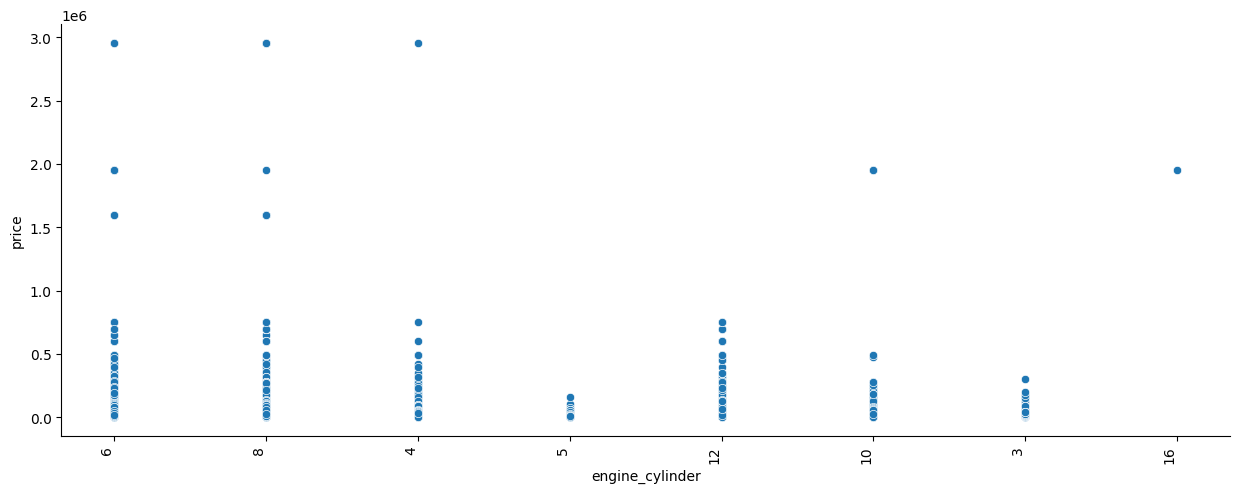

In [29]:
# Set the plot's height and aspect ratio
sns.relplot(x="engine_cylinder", y="price", data=df, height=5, aspect=2.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot
plt.show()

In [24]:
df['engine_cylinder'].replace('Value Missing', np.nan, inplace=True)
df['engine_cylinder'] = df['engine_cylinder'].astype(float)
df['engine_cylinder'].mean()

6.202572741194487

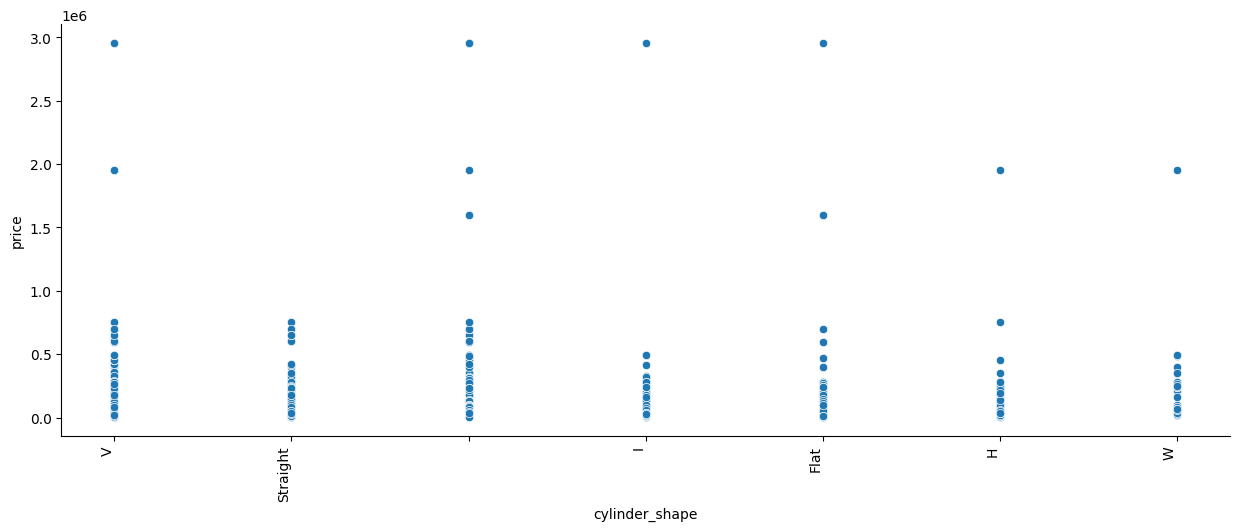

In [30]:
# Set the plot's height and aspect ratio
sns.relplot(x="cylinder_shape", y="price", data=df, height=5, aspect=2.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot
plt.show()

In [25]:
df['cylinder_shape'].replace('', np.nan, inplace=True)

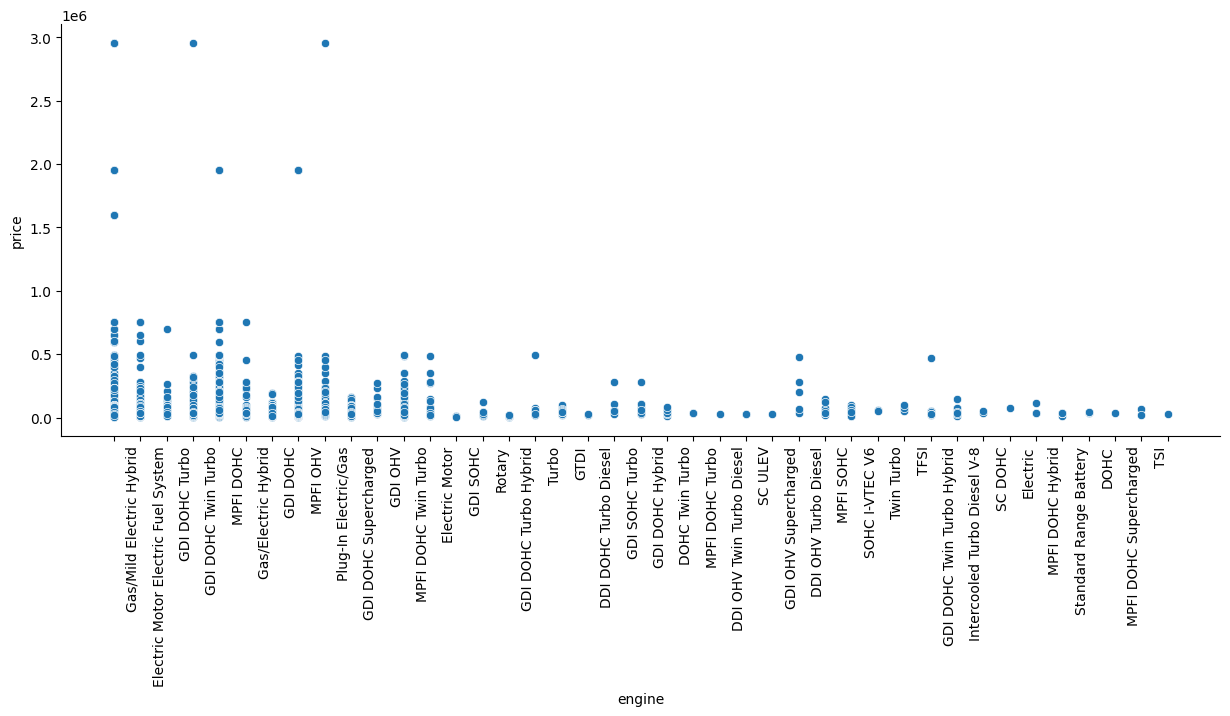

In [31]:
# Set the plot's height and aspect ratio
sns.relplot(x="engine", y="price", data=df, height=5, aspect=2.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot
plt.show()

# <span style='color: green;'>TRANSMISSION</span>

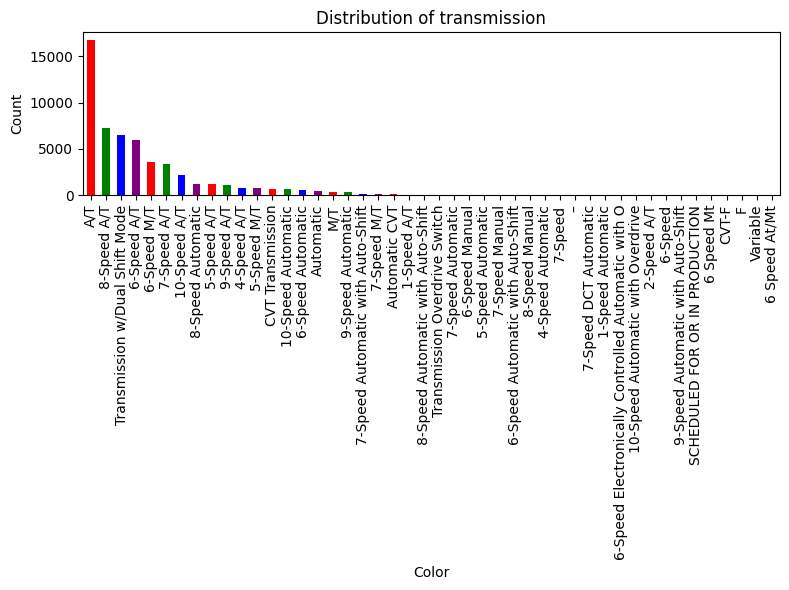

In [25]:
# Get value counts
value_counts = df['transmission'].value_counts()

# Create bar chart
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color=['red', 'green', 'blue', 'purple'])  # Optional: customize colors
plt.xlabel('Color')
plt.ylabel('Count')
plt.title('Distribution of transmission')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for readability (if many categories)
plt.tight_layout()
plt.show()

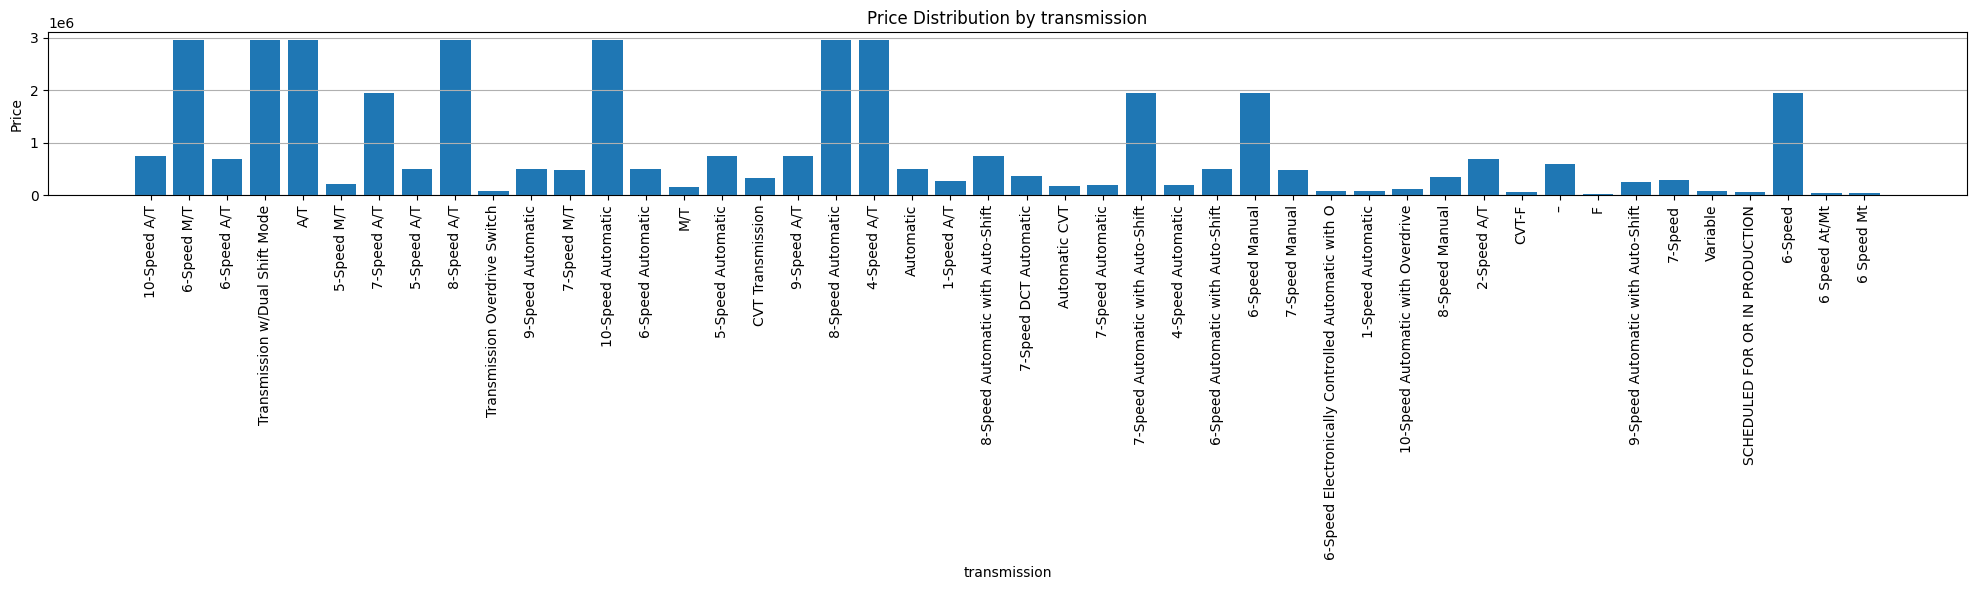

In [14]:
plt.figure(figsize=(20, 6))  # Adjust figure size as needed 
plt.bar(df['transmission'], df['price'])  # X-axis: int_col, Y-axis: price
plt.xlabel('transmission')
plt.ylabel('Price')
plt.title('Price Distribution by transmission')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability

# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

## Data cleaning for column: Transmission

In [28]:
# Function to extract the number of gears
def extract_gears(transmission):
    if 'CVT' in transmission:
        return 0

    match = re.search(r'(\d+)[-\s]?Speed', transmission, re.IGNORECASE)
    return int(match.group(1)) if match else np.nan

# Apply the function to the transmission column
df['gears'] = df['transmission'].apply(extract_gears)

In [29]:
# Insert 'Gears' column before 'Transmission' column
cols = df.columns.tolist()
cols.insert(cols.index('transmission'), cols.pop(cols.index('gears')))
df = df[cols]

In [60]:
df['transmission'].str.contains('Speed').sum() + df['transmission'].str.contains('CVT').sum()

27424

In [70]:
df.isnull().sum()

id                     0
brand                  0
model                  0
model_year             0
milage                 0
fuel_type            121
engine_power        3473
engine_volume        296
engine_cylinder      391
cylinder_shape     25431
engine                 0
gears              21942
transmission           3
ext_col                0
int_col                0
accident               0
clean_title            0
price                  0
dtype: int64

In [ ]:
# Group by 'transmission' and aggregate based on 'gears'
grouped_df = df.groupby(['transmission', 'gears']).agg({
    'price': ['max', 'mean', 'std', 'count']  # Example aggregations: sum, mean, std, count
}).reset_index()

# Flattening the column names
grouped_df.columns = ['transmission', 'gears', 'max_price', 'average_price', 'price_std', 'count']

# Display the grouped DataFrame
grouped_df.sort_values('max_price', ascending=True)

In [30]:
# Updated mapping of column: transmission
transmission_map = {
    'Automatic': [
        'A/T', '8-Speed A/T', '6-Speed A/T', '7-Speed A/T', '10-Speed A/T', '8-Speed Automatic', '5-Speed A/T', '9-Speed A/T', '4-Speed A/T', 
        '10-Speed Automatic', '6-Speed Automatic', 'Automatic', '9-Speed Automatic', '7-Speed Automatic', '5-Speed Automatic',  
        '1-Speed A/T', '8-Speed Automatic with Auto-Shift', '6-Speed Automatic with Auto-Shift', '4-Speed Automatic', '7-Speed', 
        '2-Speed A/T', '9-Speed Automatic with Auto-Shift', '1-Speed Automatic', '6 Speed At/Mt', '7-Speed Automatic with Auto-Shift'
    ],
    'Manual': [
        '6-Speed M/T', '5-Speed M/T', '7-Speed M/T', '6-Speed Manual', '7-Speed Manual', '8-Speed Manual', '6 Speed Mt', 'M/T'
    ],
    'CVT': [
        'CVT Transmission', 'Automatic CVT', 'CVT-F', 'F', 'Variable'
    ],
    'Dual-Clutch': [
        'Transmission w/Dual Shift Mode', '7-Speed DCT Automatic'
    ],
    'Overdrive': [
        'Transmission Overdrive Switch', '6-Speed Electronically Controlled Automatic with O', '10-Speed Automatic with Overdrive'
    ],
    
}

# Function to map transmission types
def map_transmissions(transmission):
    if transmission == '–':
        return np.nan
    if transmission ==  'SCHEDULED FOR OR IN PRODUCTION':
        return np.nan
#    if transmission ==  '6-Speed':
#        return np.nan
    for key, values in transmission_map.items():
        if transmission in values:
            return key
    return 'other'
    
# Assuming `df` is the DataFrame for the transmission column
df['transmission'] = df['transmission'].apply(map_transmissions)
# Fill NaN values in transmission with a placeholder
df['gears'] = df['gears'].astype(float)

In [32]:
df['transmission'].isnull().sum()#value_counts()

3

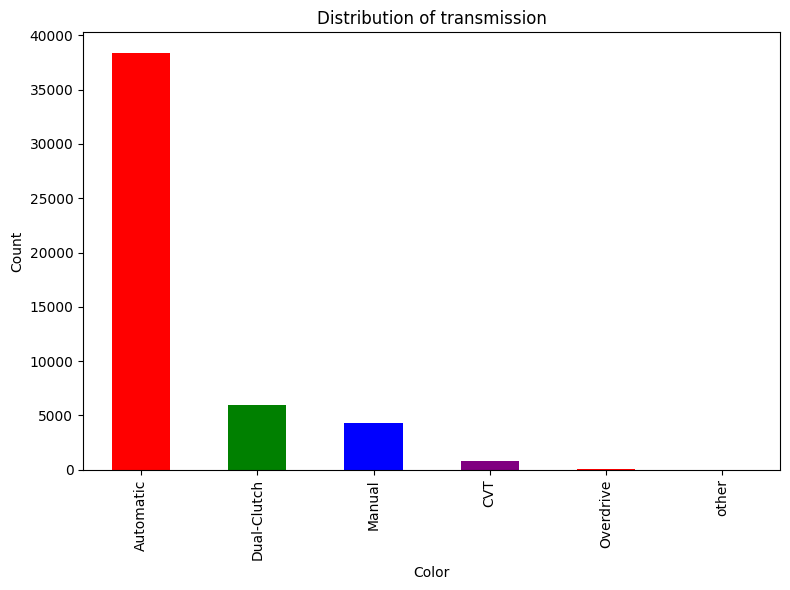

In [68]:
# Get value counts
value_counts = df['transmission'].value_counts()

# Create bar chart
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color=['red', 'green', 'blue', 'purple'])  # Optional: customize colors
plt.xlabel('Color')
plt.ylabel('Count')
plt.title('Distribution of transmission')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for readability (if many categories)
plt.tight_layout()
plt.show()

In [ ]:
# Fill NaN values in transmission with a placeholder
#df['transmission'].fillna('Value Missing', inplace=True)

plt.figure(figsize=(20, 6))  # Adjust figure size as needed 
plt.bar(df['transmission'], df['price'])  # X-axis: int_col, Y-axis: price
plt.xlabel('transmission')
plt.ylabel('Price')
plt.title('Price Distribution by transmission')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability

# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

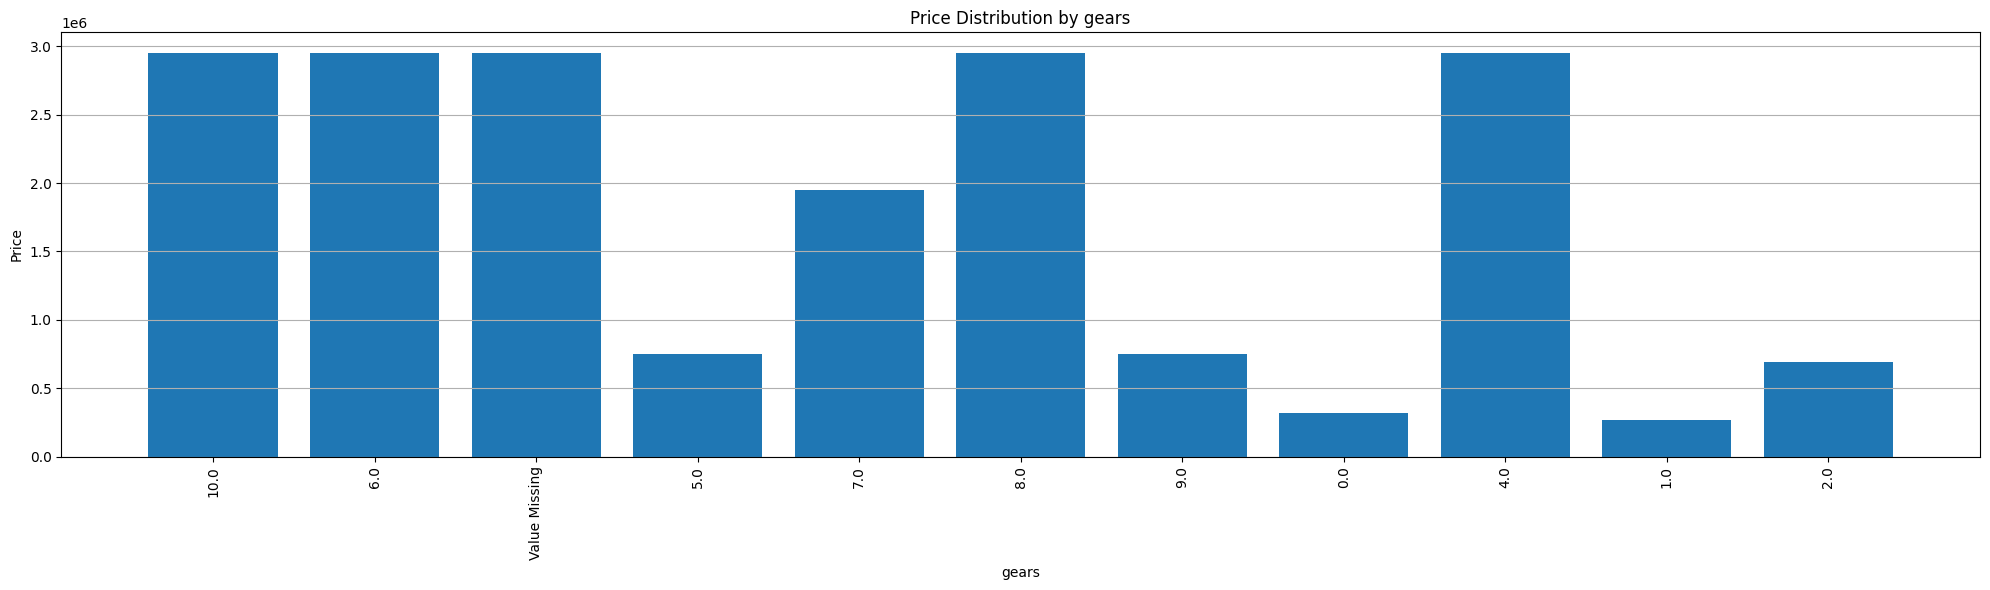

In [51]:
plt.figure(figsize=(20, 6))  # Adjust figure size as needed 
plt.bar(df['gears'], df['price'])  # X-axis: int_col, Y-axis: price
plt.xlabel('gears')
plt.ylabel('Price')
plt.title('Price Distribution by gears')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability

# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

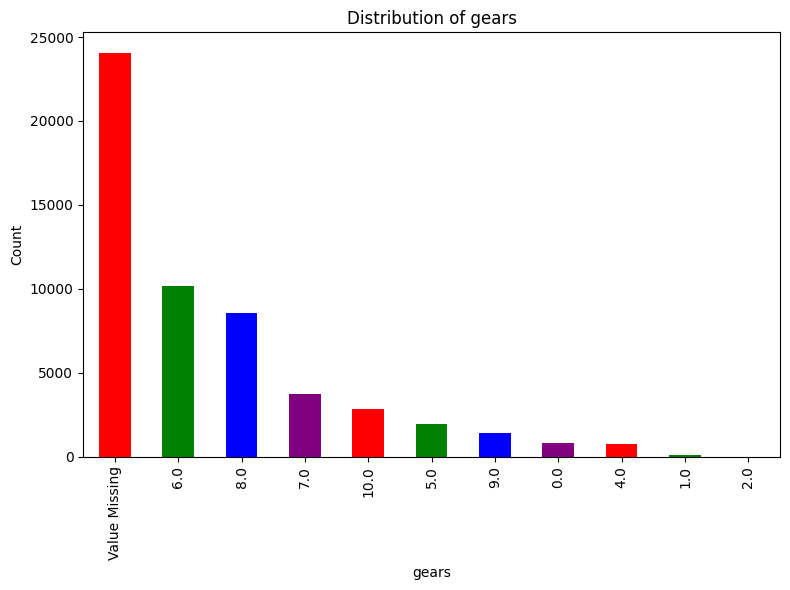

In [52]:
# Get value counts
value_counts = df['gears'].value_counts()

# Create bar chart
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color=['red', 'green', 'blue', 'purple'])  # Optional: customize colors
plt.xlabel('gears')
plt.ylabel('Count')
plt.title('Distribution of gears')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for readability (if many categories)
plt.tight_layout()
plt.show()

In [116]:
from sklearn.feature_selection import mutual_info_regression
# Calculate mutual information for categorical variables
def calculate_mutual_info(df, target):
    categorical_columns = ['gears']
    mi = mutual_info_regression(pd.get_dummies(df[categorical_columns]), df[target])
    mi_series = pd.Series(mi, index=pd.get_dummies(df[categorical_columns]).columns)
    return mi_series

mi_scores = calculate_mutual_info(df, 'price')
mi_score = mi_scores.sum()
mi_score

0.19572828260021646

# <span style='color: green;'>ACCIDENT</span>

In [34]:
# Replace values in 'accident' column
df['accident'] = df['accident'].replace({'None reported': 0, 'At least 1 accident or damage reported': 1})

In [76]:
df['accident'].value_counts()

accident
0    39896
1    14377
Name: count, dtype: int64

# <span style='color: green;'>EXTERNAL COLOR</span>

In [81]:
df['ext_col'].value_counts()

ext_col
Black                                      15078
White                                      13422
Gray                                        7909
Silver                                      5161
Blue                                        4668
Red                                         3013
Green                                        763
Gold                                         484
Beige                                        455
Brown                                        386
Orange                                       328
Yellow                                       306
Agate Black Metallic                         113
Bright White Clearcoat                       105
Purple                                        94
Summit White                                  88
Black Clearcoat                               83
Diamond Black                                 72
Silver Ice Metallic                           62
Delmonico Red Pearlcoat                       56
Soul Red Cry

In [83]:
df[df['ext_col'] ==  'Rosso Corsa']

,id,brand,model,model_year,milage,fuel_type,engine_power,engine_volume,engine_cylinder,cylinder_shape,engine,gears,transmission,ext_col,int_col,accident,clean_title,price
17125,17125,Ferrari,488 GTB Base,2018,17761,Gasoline,NaN,3.9,8,V,GDI DOHC Twin Turbo,7.0,Automatic,Rosso Corsa,Nero,0,Yes,417500
24017,24017,Alfa,488 GTB Base,2021,3596,Gasoline,NaN,2.9,6,V,GDI DOHC Twin Turbo,8.0,Automatic,Rosso Corsa,Black,0,Yes,89995
24021,24021,Ferrari,GTC4Lusso T,2022,4860,Gasoline,NaN,3.0,6,V,GDI DOHC Twin Turbo,8.0,Automatic,Rosso Corsa,Black,0,Yes,68362
28525,28525,Ferrari,488 GTB Base,2023,1716,Gasoline,NaN,3.9,8,V,GDI DOHC Twin Turbo,7.0,Automatic,Rosso Corsa,Nero Ade,0,Yes,359991
42779,42779,Lamborghini,570S Spider,2018,17761,Gasoline,NaN,5.2,10,V,GDI DOHC,7.0,Automatic,Rosso Corsa,White,0,Yes,1950995
45640,45640,Ferrari,488 GTB Base,2021,17761,Gasoline,NaN,3.9,8,V,GDI DOHC Twin Turbo,7.0,Dual-Clutch,Rosso Corsa,Nero,0,Yes,359991


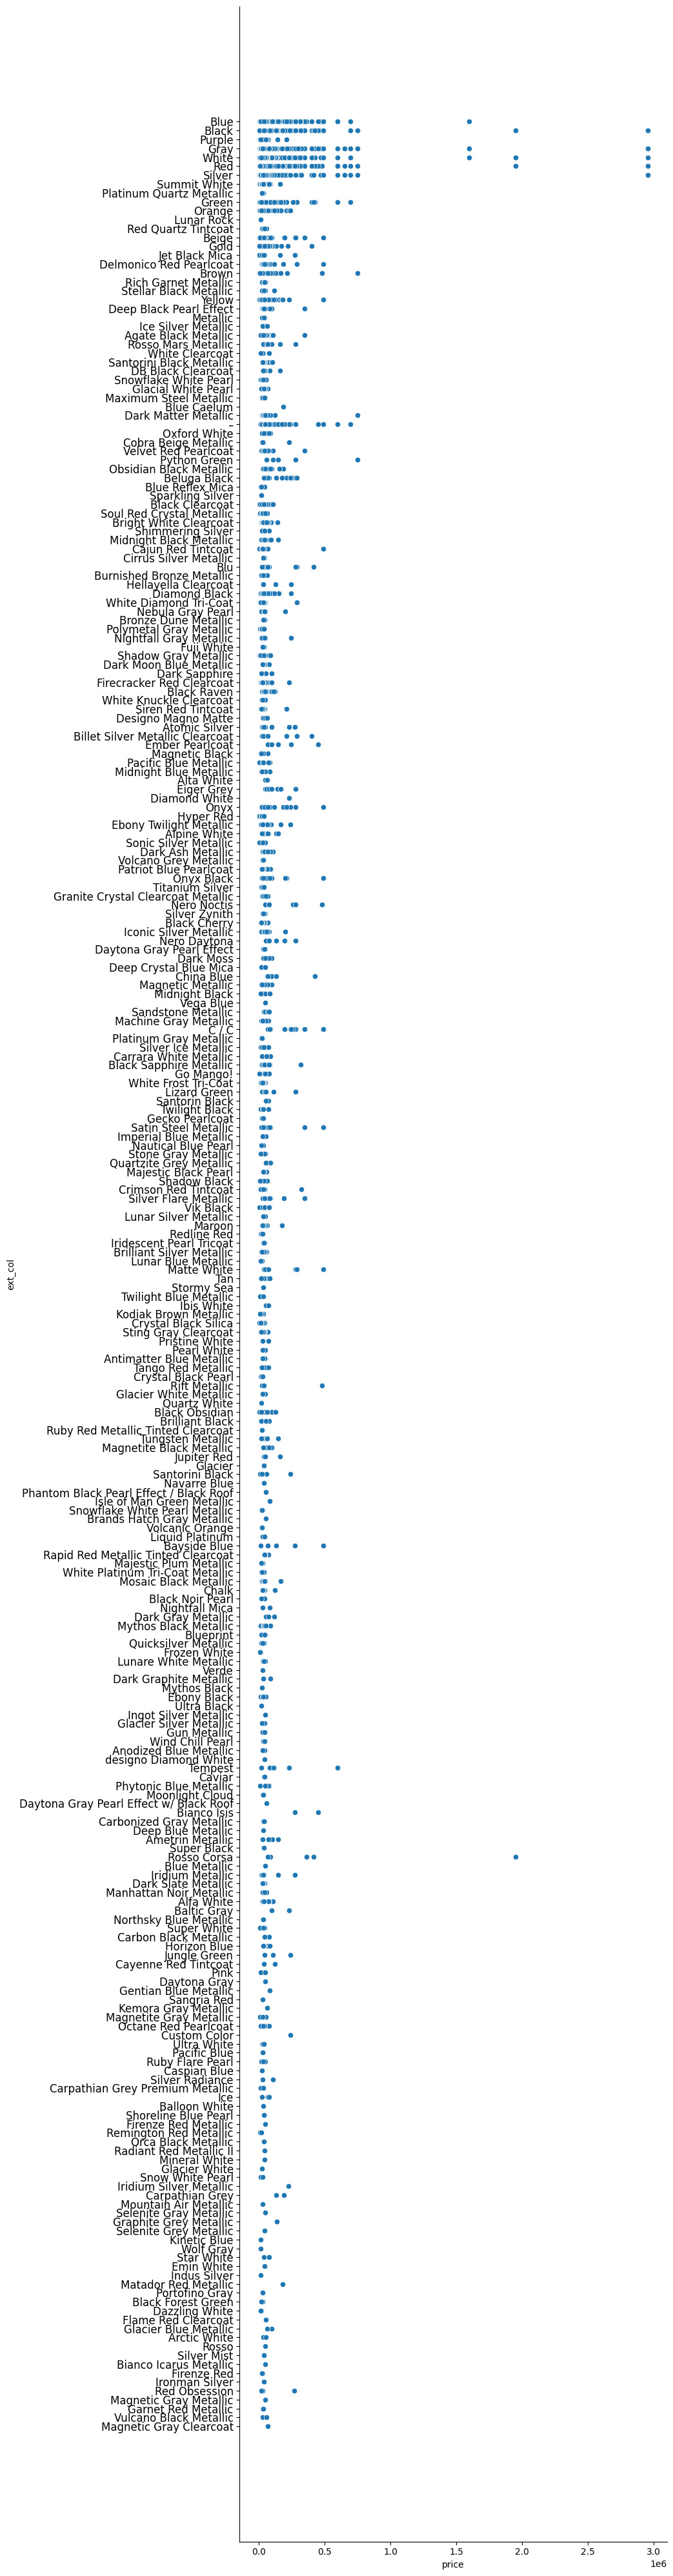

In [80]:
# Set the plot's height and aspect ratio
sns.relplot(x="price", y="ext_col", data=df, height=40, aspect=0.25)

# Adjust the y-ticks to add more spacing
ext_col = df['ext_col'].unique()
positions = range(len(ext_col))

plt.yticks(ticks=positions, labels=ext_col, rotation=0, fontsize=12)  # Adjust fontsize and rotation as needed


# Show the plot
plt.show()

In [90]:
# Mapping of synonymous colors for 'ext_col' columns
color_mapping = {
    'Black': [
        'Black', 'Agate Black Metallic', 'Black Clearcoat', 'Diamond Black', 'Jet Black', 'Midnight Black', 'Ebony Black',
        'Deep Black Pearl Effect', 'Black Obsidian', 'Onyx Black', 'Black Raven', 'Brilliant Black', 'Black Cherry', 'Shadow Black',
        'Ebony Twilight Metallic', 'Jet Black Mica', 'Dark Matter Metallic', 'Black Sapphire Metallic', 'Midnight Black Metallic',
        'Beluga Black', 'Mosaic Black Metallic', 'Obsidian Black Metallic', 'DB Black Clearcoat', 'Santorini Black Metallic',
        'Mythos Black Metallic', 'Vik Black', 'Manhattan Noir Metallic', 'Stellar Black Metallic', 'Santorini Black', 'Magnetite Black Metallic',
        'Nero Daytona', 'Majestic Black Pearl', 'Crystal Black Pearl', 'Santorin Black', 'Black Noir Pearl', 'Vulcano Black Metallic', 'Ultra Black',
        'Mythos Black', 'Super Black', 'Phantom Black Pearl Effect / Black Roof', 'Orca Black Metallic'
    ],
    'White': [
        'White', 'Bright White Clearcoat', 'Summit White', 'Snowflake White Pearl', 'Glacial White Pearl', 'White Frost Tri-Coat',
        'White Diamond Tri-Coat', 'Alpine White', 'Oxford White', 'Ultra White', 'Super White', 'White Knuckle Clearcoat', 'Frozen White',
        'Snow White Pearl', 'White Clearcoat', 'Matte White', 'White Platinum Tri-Coat Metallic', 'Lunare White Metallic', 'Snowflake White Pearl Metallic',
        'Alta White', 'Glacier White Metallic', 'Arctic White', 'Dazzling White', 'Pristine White', 'Fuji White', 'Ibis White', 'Pearl White', 'Emin White',
        'Glacier White', 'designo Diamond White', 'Mineral White', 'Quartz White'
    ],
    'Gray': [
        'Gray', 'Shadow Gray Metallic', 'Dark Gray Metallic', 'Machine Gray Metallic', 'Polymetal Gray Metallic', 'Magnetic Metallic',
        'Satin Steel Metallic', 'Gun Metallic', 'Carbonized Gray Metallic', 'Platinum Gray Metallic', 'Graphite Gray Metallic',
        'Daytona Gray', 'Maximum Steel Metallic', 'Nightfall Gray Metallic', 'Eiger Grey', 'Dark Slate Metallic', 'Stone Gray Metallic', 'Tempest',
        'Magnetite Gray Metallic', 'Designo Magno Matte', 'Volcano Grey Metallic', 'Dark Graphite Metallic', 'Quartzite Grey Metallic',
        'Carpathian Grey Premium Metallic', 'Rift Metallic', 'Baltic Gray', 'Portofino Gray', 'Moonlight Cloud', 'Carpathian Grey', 'Silver Mist', 
        'Lunar Silver Metallic', 'Graphite Grey Metallic', 'Selenite Grey Metallic', 'Selenite Gray Metallic', 'Kemora Gray Metallic', 
        'Magnetic Gray Metallic', 'Brands Hatch Gray Metallic'
    ],
    'Silver': [
        'Silver', 'Silver Ice Metallic', 'Iconic Silver Metallic', 'Tungsten Metallic', 'Billet Silver Metallic Clearcoat',
        'Brilliant Silver Metallic', 'Atomic Silver', 'Blade Silver Metallic', 'Silver Radiance', 'Ingot Silver Metallic',
        'Silver Flare Metallic', 'Sonic Silver Metallic', 'Silver Zynith', 'Iridium Metallic', 'Ice Silver Metallic', 'Shimmering Silver',
        'Glacier Silver Metallic', 'Quicksilver Metallic', 'Cirrus Silver Metallic', 'Titanium Silver', 'Sparkling Silver', 'Ironman Silver'
    ],
    'Blue': [
        'Blue', 'Patriot Blue Pearlcoat', 'Antimatter Blue Metallic', 'Dark Moon Blue Metallic', 'China Blue', 'Imperial Blue Metallic',
        'Blueprint', 'Nautical Blue Pearl', 'Pacific Blue', 'Blue Reflex Mica', 'Twilight Blue Metallic', 'Deep Crystal Blue Mica',
        'Stormy Sea', 'Horizon Blue', 'Glacier Blue Metallic', 'Northsky Blue Metallic', 'Phytonic Blue Metallic', 'Manhattan Blue Metallic',
        'Santorini Blue', 'Blu', 'Pacific Blue Metallic', 'Bayside Blue', 'Blue Caelum', 'Gentian Blue Metallic', 'Kinetic Blue', 'Vega Blue', 'Navarre Blue',
        'Deep Blue Metallic', 'Blue Metallic', 'Caspian Blue', 'Balloon White'
    ],
    'Red': [
        'Red', 'Delmonico Red Pearlcoat', 'Soul Red Crystal Metallic', 'Firecracker Red Clearcoat', 'Redline Red', 'Velvet Red Pearlcoat',
        'Crimson Red Tintcoat', 'Rich Garnet Metallic', 'Sting Gray Clearcoat', 'Tango Red Metallic', 'Hyper Red', 'Maroon',
        'Red Quartz Tintcoat', 'Ruby Red Metallic', 'Red Obsession', 'Garnet Red Metallic', 'Flame Red Clearcoat', 'Go Mango!',
        'Radiant Red Metallic II', 'Octane Red Pearlcoat', 'Siren Red Tintcoat', 'Rosso Mars Metallic', 'Rosso Corsa', 'Rapid Red Metallic Tinted Clearcoat',
        'Cayenne Red Tintcoat', 'Remington Red Metallic', 'Sangria Red', 'Ruby Flare Pearl', 'Rosso', 'Matador Red Metallic'
    ],
    'Green': [
        'Green', 'Lizard Green', 'Isle of Man Green Metallic', 'Forest Green', 'Black Forest Green', 'Jungle Green', 'Dark Moss', 'Verde'
    ],
    'Gold': ['Gold'],
    'Beige': [
        'Beige', 'Cobra Beige Metallic', 'Tan', 'Sandstone Metallic'
    ],
    'Brown': ['Brown', 'Kodiak Brown Metallic'],
    'Orange': [
        'Orange', 'Go Mango!', 'Hellayella Clearcoat', 'Volcanic Orange', 'Burnished Bronze Metallic'
    ],
    'Yellow': ['Yellow'],
    'Purple': ['Purple'],
    'Pink': ['Pink'],
    'White': ['White', 'Alfa White', 'Iridescent Pearl Tricoat'],
    'Other': ['C / C', 'Metallic', 'Python Green', 'Ametrin Metallic', 'Ember Pearlcoat', 'Lunar Rock', 'Custom Color', 'designo Diamond White']
}

# Function to map colors
def map_colors(color):
    for key, values in color_mapping.items():
        if color in values:
            return key
        if color == '–':
            return 'NaN'
    return 'Other'

# Apply the mapping function
df['ext_col'] = df['ext_col'].apply(map_colors)

# <span style='color: green;'>INTERNAL COLOR</span>

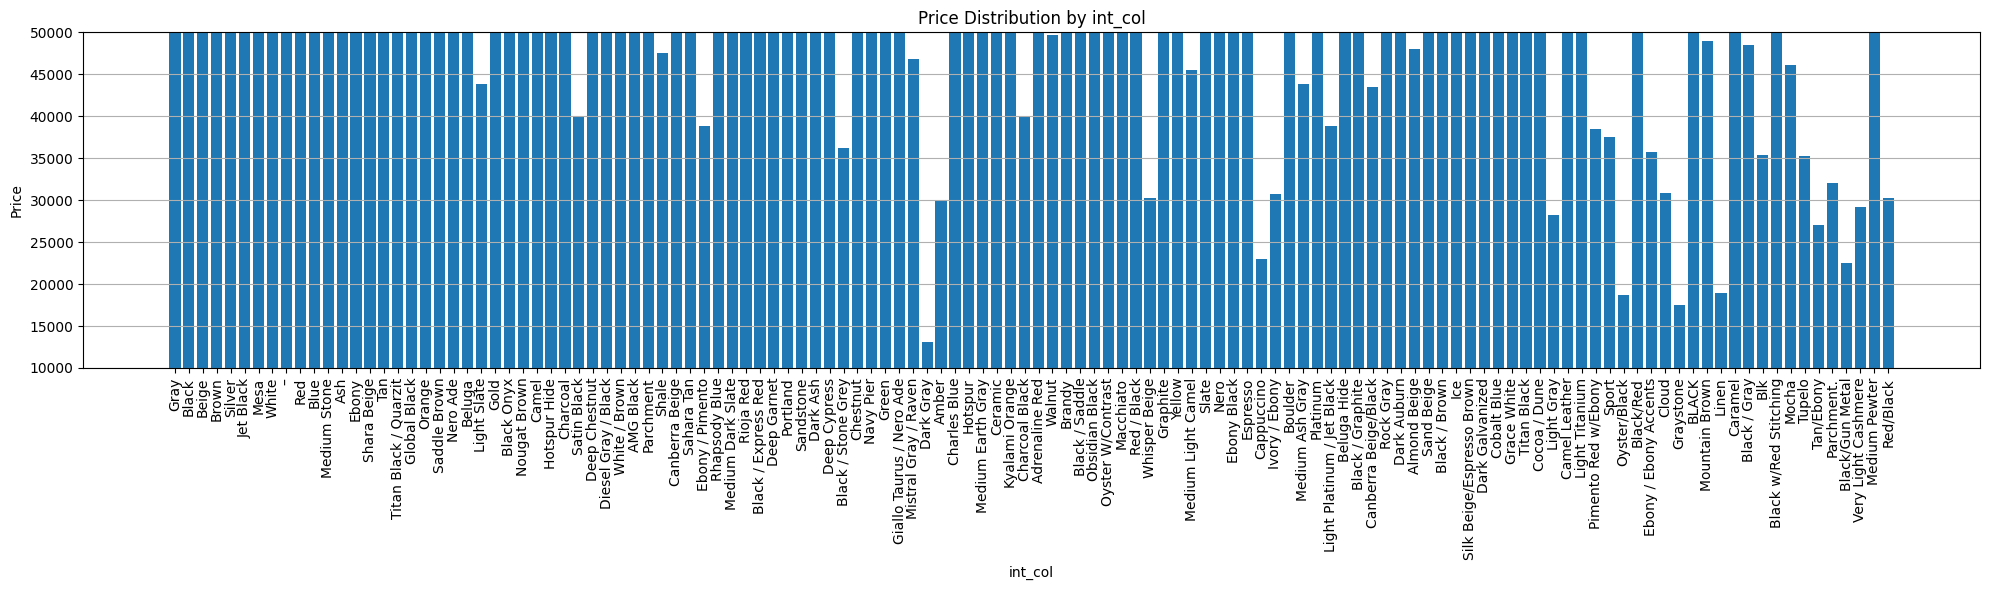

In [13]:
plt.figure(figsize=(20, 6))  # Adjust figure size as needed 
plt.bar(df['int_col'], df['price'])  # X-axis: int_col, Y-axis: price
plt.xlabel('int_col')
plt.ylabel('Price')
plt.title('Price Distribution by int_col')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability
plt.ylim( ymin=10000, ymax=50000 )
# Customize the plot (optional)
plt.grid(axis='y')  # Add grid lines on the Y-axis
plt.tight_layout()  # Adjust spacing between elements

# Display the plot
plt.show()

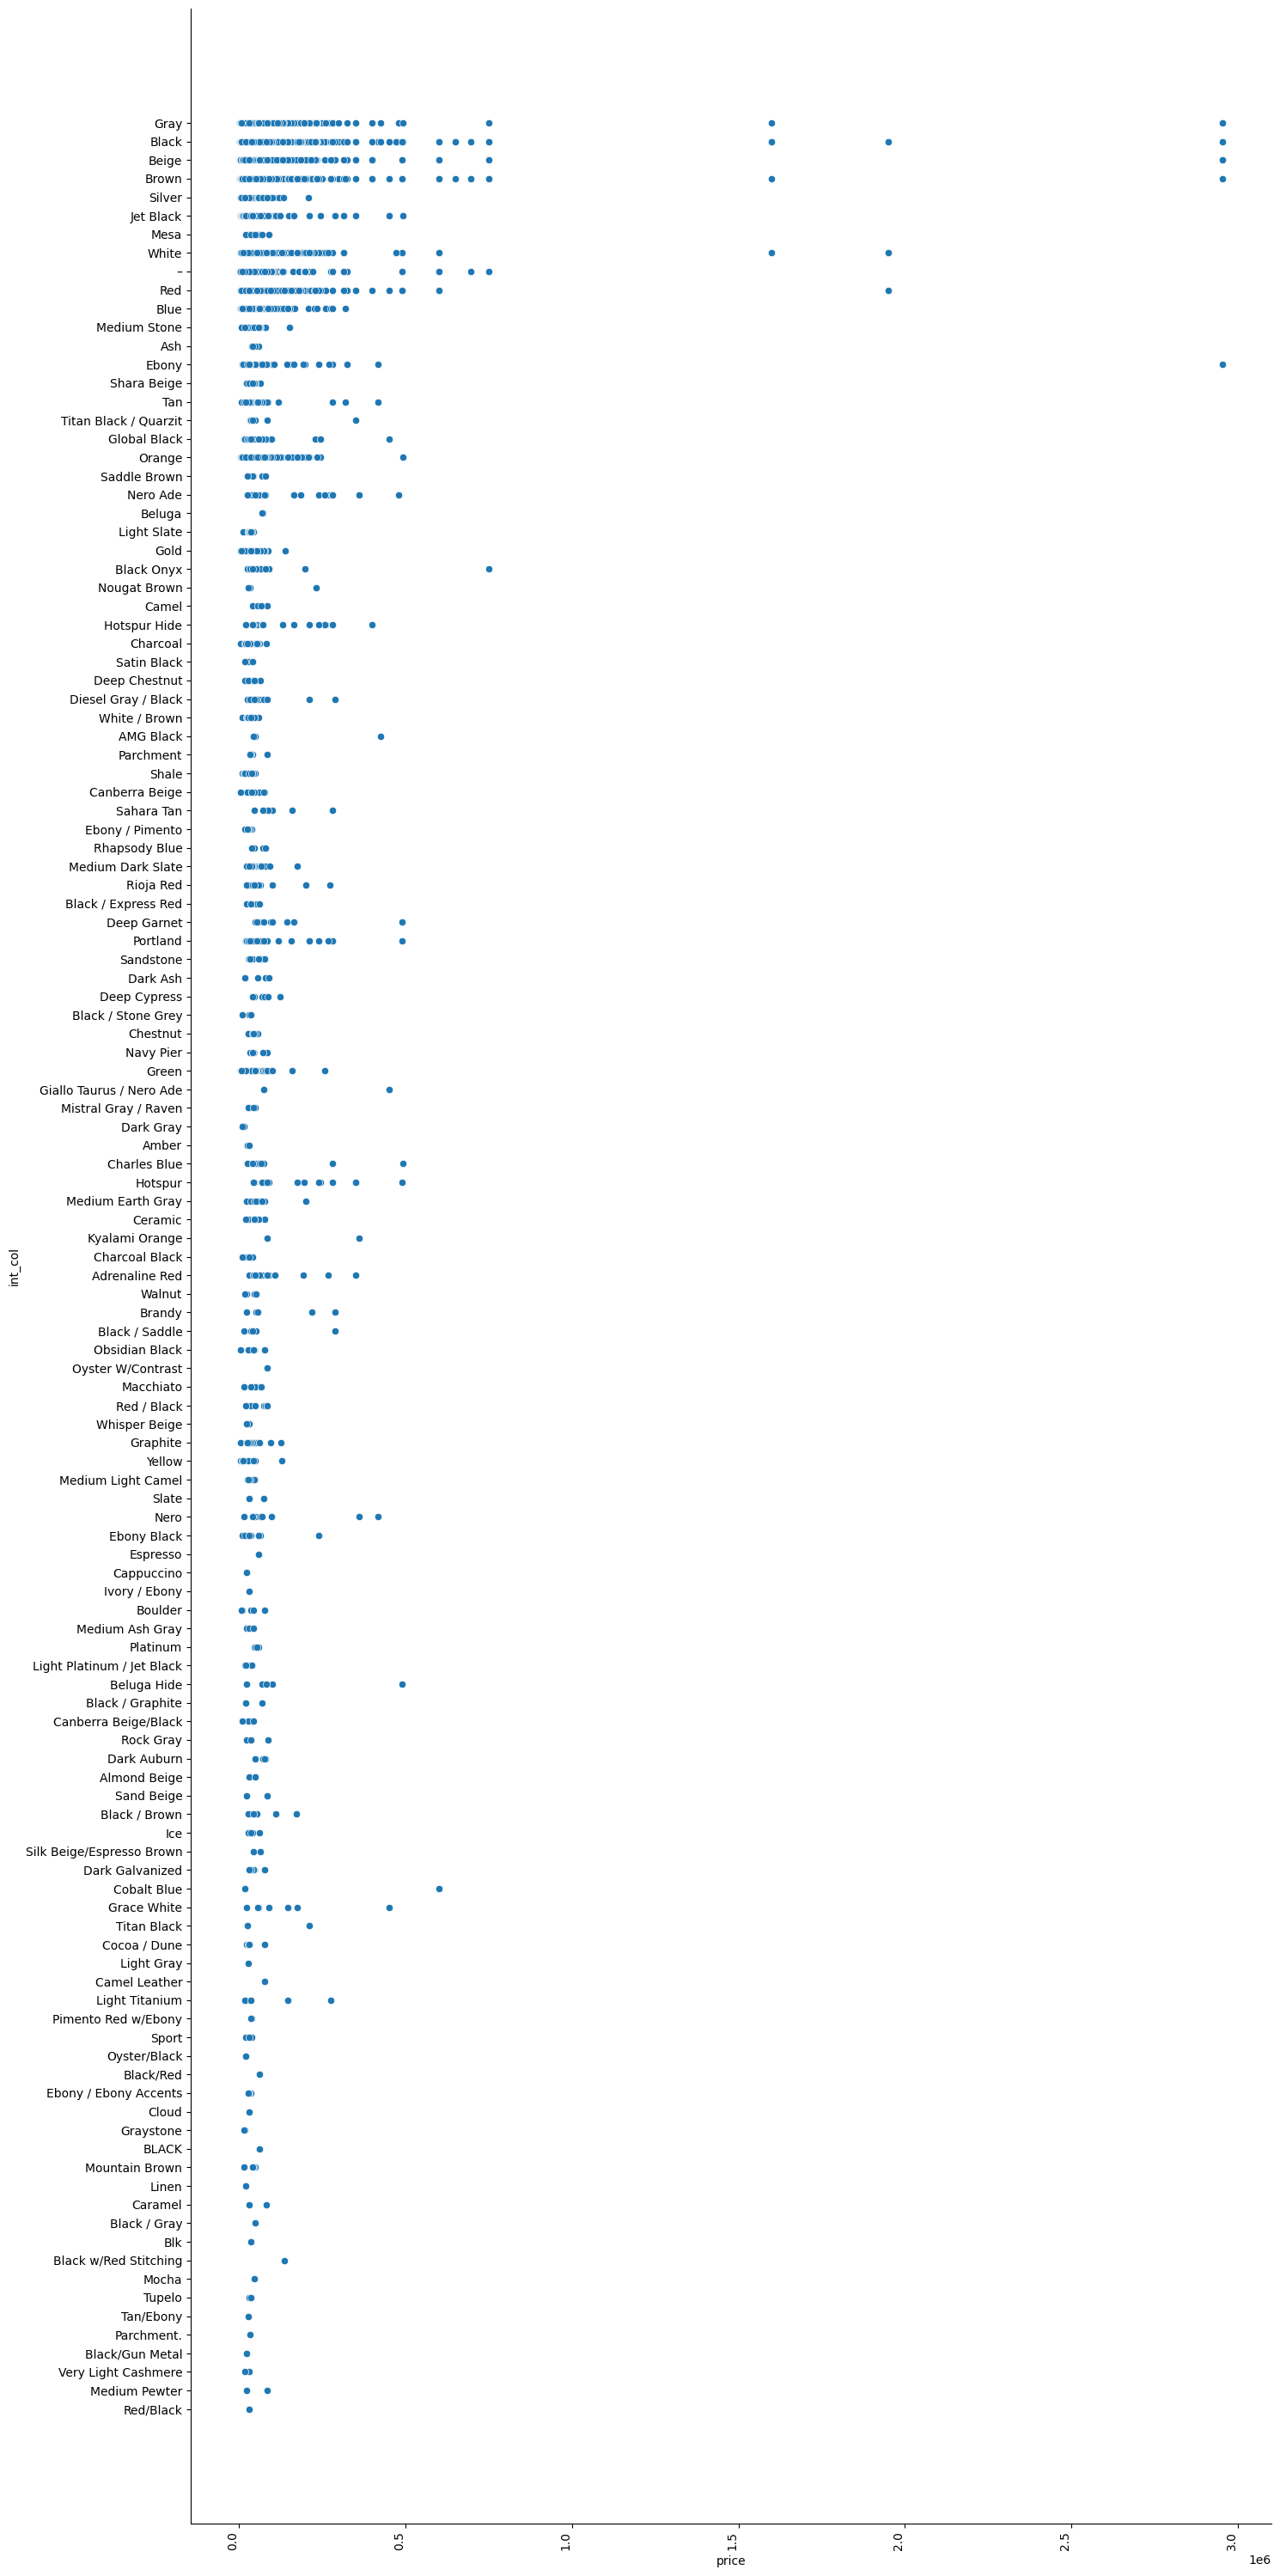

In [12]:
# Set the plot's height and aspect ratio
sns.relplot(x="price", y="int_col", data=df, height=30, aspect=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right')

# Show the plot
plt.show()

In [91]:
# Updated mapping of synonymous colors for the 'int_col'
color_map = {
    'Black': [
        'Black', 'Jet Black', 'Ebony', 'Global Black', 'Black Onyx', 'Nero Ade', 'Ebony Black', 'Charcoal Black', 'Nero', 'Blk', 'BLACK'
    ],
    'White': [
        'White', 'Grace White', 'Light Platinum', 'Parchment', 'Linen', 'Oyster', 'Oyster W/Contrast'
    ],
    'Gray': [
        'Gray', 'Medium Stone', 'Diesel Gray', 'Medium Dark Slate', 'Graphite', 'Medium Earth Gray', 'Light Slate', 'Shara Beige', 'Charcoal', 
        'Dark Gray', 'Dark Ash', 'Medium Ash Gray', 'Dark Galvanized', 'Graystone', 'Slate', 'Rock Gray', 'Mistral Gray'
    ],
    'Beige': [
        'Beige', 'Canberra Beige', 'Sandstone', 'Hotspur Hide', 'Medium Light Camel', 'Mesa', 'Shale', 'Very Light Cashmere', 'Tan/Ebony', 
        'Cappuccino', 'Canberra Beige/Black', 'Sahara Tan', 'Camel', 'Cocoa', 'Camel Leather', 'Nougat Brown', 'Sand Beige', 'Almond Beige'
    ],
    'Brown': [
        'Brown', 'Deep Chestnut', 'Navy Pier', 'Chestnut', 'Deep Cypress', 'Saddle Brown', 'Amber', 'Walnut', 'Mocha', 'Dark Auburn', 'Brandy'
    ],
    'Red': [
        'Red', 'Rioja Red', 'Hotspur', 'Adrenaline Red', 'Red / Black', 'Deep Garnet', 'Pimento Red', 'Giallo Taurus / Nero Ade'
    ],
    'Blue': [
        'Blue', 'Charles Blue', 'Rhapsody Blue', 'Navy Pier', 'Cobalt Blue', 'Canberra Beige/Black', 'Beluga', 'Ceramic', 'Deep Blue Metallic'
    ],
    'Silver': [
        'Silver', 'Ice', 'Silver Radiance', 'Titan Black', 'Slate'
    ],
    'Gold': ['Gold'],
    'Green': ['Green', 'Deep Cypress'],
    'Orange': ['Orange', 'Kyalami Orange'],
    'Yellow': ['Yellow'],
    'two colors': [],  # Placeholder for two-color combinations
    'NaN': ['–']  # Placeholder for missing values
}

# Function to map colors
def map_new_colors(color):
    if '/' in color:
        return 'two colors'
    elif color == '–':
        return 'NaN'
    for key, values in color_map.items():
        if color in values:
            return key
    return 'Other'

# Assuming `df_new` is the DataFrame for the new column
df['int_col'] = df['int_col'].apply(map_new_colors)

In [37]:
df['clean_title'].value_counts()

clean_title
Yes    49366
Name: count, dtype: int64

In [38]:
df.to_csv('clean_train.csv', index=False)
#df.to_csv('clean_test.csv', index=False)

In [95]:
df = pd.read_csv('clean_train.csv')
df.head()

,id,brand,model,model_year,milage,fuel_type,engine_power,engine_volume,engine_cylinder,cylinder_shape,engine,gears,transmission,ext_col,int_col,accident,clean_title,price
0,0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0,3.5,6.0,V,0,10.0,Automatic,Blue,Gray,0,Yes,11000
1,1,BMW,335 i,2007,80000,Gasoline,300.0,3.0,6.0,Straight,0,6.0,Manual,Black,Black,0,Yes,8250
2,2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0,4.2,8.0,0,0,6.0,Automatic,Purple,Beige,0,Yes,15000
3,3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0,3.0,6.0,Straight,Gas/Mild Electric Hybrid,0.0,Dual-Clutch,Gray,Brown,0,Yes,63500
4,5,Acura,Integra LS,2003,124756,Gasoline,140.0,1.8,4.0,0,0,5.0,Manual,Red,Beige,1,Yes,4995


In [106]:
df.isnull().sum()

id                 0
brand              0
model              0
model_year         0
milage             0
fuel_type          0
engine_power       0
engine_volume      0
engine_cylinder    0
cylinder_shape     0
engine             0
gears              0
transmission       0
ext_col            0
int_col            0
accident           0
clean_title        0
price              0
dtype: int64

In [97]:
X = df.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [98]:
X.fillna('0', inplace=True)
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

milage             0.843429
model              0.345041
gears              0.169230
int_col            0.105177
engine_cylinder    0.064238
clean_title        0.002903
Name: MI Scores, dtype: float64

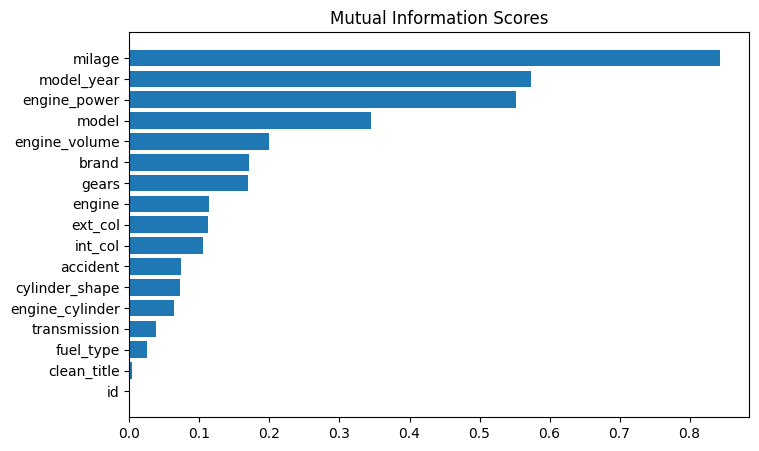

In [99]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [100]:
numeric_features = df.select_dtypes(include=['int64', 'float64'])
# Calculate correlation matrix for categorical columns (if applicable)
if not numeric_features.empty:
  pearson_corr_matrix = numeric_features.corr(method='pearson')  # Spearman for categorical data
  print("Correlation Matrix (numerical features):")
else:
  print("No numerical columns found in the DataFrame for correlation.")
pearson_corr_matrix

Correlation Matrix (numerical features):


,id,model_year,milage,engine_power,engine_volume,engine_cylinder,gears,accident,price
id,1.000000,0.000064,-0.003082,-0.005320,-0.000176,0.001232,0.004804,-0.002090,-0.000020
model_year,0.000064,1.000000,-0.640546,0.103299,-0.016300,-0.030383,0.230701,-0.229185,0.628701
milage,-0.003082,-0.640546,1.000000,-0.174314,-0.016625,-0.040045,-0.228431,0.292505,-0.646025
engine_power,-0.005320,0.103299,-0.174314,1.000000,0.494892,0.559515,0.016037,-0.081222,0.321325
engine_volume,-0.000176,-0.016300,-0.016625,0.494892,1.000000,0.888202,0.073441,-0.041953,0.207263
engine_cylinder,0.001232,-0.030383,-0.040045,0.559515,0.888202,1.000000,0.087095,-0.049244,0.229441
gears,0.004804,0.230701,-0.228431,0.016037,0.073441,0.087095,1.000000,-0.101897,0.230267
accident,-0.002090,-0.229185,0.292505,-0.081222,-0.041953,-0.049244,-0.101897,1.000000,-0.264987
price,-0.000020,0.628701,-0.646025,0.321325,0.207263,0.229441,0.230267,-0.264987,1.000000


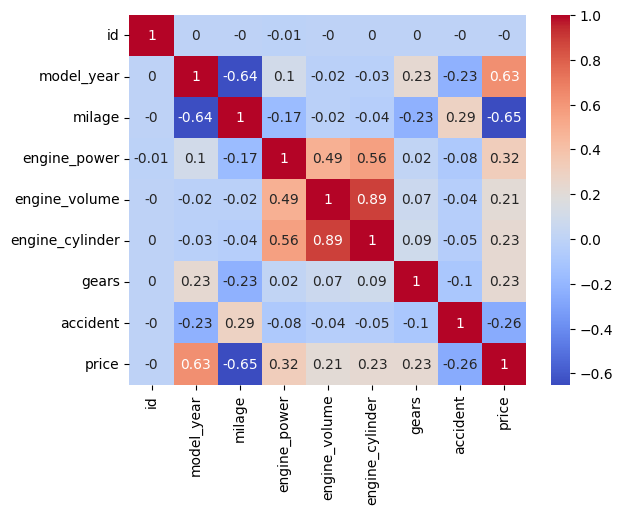

In [101]:
sns.heatmap(round(pearson_corr_matrix,2), annot=True, cmap='coolwarm')
plt.show()

In [102]:
numeric_features = df.select_dtypes(include=['int64', 'float64'])
# Calculate correlation matrix for categorical columns (if applicable)
if not numeric_features.empty:
  spearman_corr_matrix = round(numeric_features.corr(method='spearman') ,3) # Spearman for categorical data
  print("Correlation Matrix (numerical features):")
else:
  print("No numerical columns found in the DataFrame for correlation.")
spearman_corr_matrix

Correlation Matrix (numerical features):


,id,model_year,milage,engine_power,engine_volume,engine_cylinder,gears,accident,price
id,1.000,0.001,-0.004,-0.000,-0.001,0.001,0.005,-0.002,-0.000
model_year,0.001,1.000,-0.688,0.187,-0.021,0.002,0.292,-0.249,0.722
milage,-0.004,-0.688,1.000,-0.252,-0.015,-0.061,-0.265,0.287,-0.708
engine_power,-0.000,0.187,-0.252,1.000,0.585,0.669,0.110,-0.118,0.417
engine_volume,-0.001,-0.021,-0.015,0.585,1.000,0.925,0.052,-0.036,0.187
engine_cylinder,0.001,0.002,-0.061,0.669,0.925,1.000,0.081,-0.054,0.237
gears,0.005,0.292,-0.265,0.110,0.052,0.081,1.000,-0.112,0.293
accident,-0.002,-0.249,0.287,-0.118,-0.036,-0.054,-0.112,1.000,-0.284
price,-0.000,0.722,-0.708,0.417,0.187,0.237,0.293,-0.284,1.000


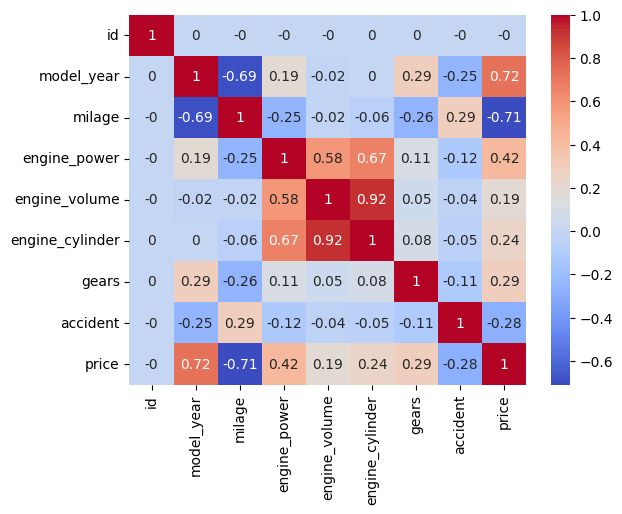

In [103]:
sns.heatmap(round(spearman_corr_matrix,2), annot=True, cmap='coolwarm')
plt.show()

## Plotting both correlation stacked side by side

In [104]:
# Define the function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# List of categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.pop()
categorical_columns.append('price')
# Initialize an empty DataFrame for the correlation matrix
chi_corr_matrix = pd.DataFrame(np.zeros((len(categorical_columns), len(categorical_columns))), 
                           index=categorical_columns, 
                           columns=categorical_columns)

# Compute Cramér's V for each pair of categorical columns
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            chi_corr_matrix.loc[col1, col2] = 1.0
        else:
            chi_corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

chi_corr_matrix

,brand,model,fuel_type,cylinder_shape,engine,transmission,ext_col,int_col,price
brand,1.000000,0.962462,0.177203,0.443168,0.192331,0.215195,0.182661,0.167890,0.119682
model,0.962462,1.000000,0.798105,0.770751,0.569708,0.483557,0.353366,0.388938,0.116479
fuel_type,0.177203,0.798105,1.000000,0.084731,0.684839,0.069739,0.000000,0.052243,0.072926
cylinder_shape,0.443168,0.770751,0.084731,1.000000,0.394129,0.104786,0.396372,0.337676,0.262968
engine,0.192331,0.569708,0.684839,0.394129,1.000000,0.141784,0.397303,0.386518,0.268832
transmission,0.215195,0.483557,0.069739,0.104786,0.141784,1.000000,0.217864,0.090883,0.172190
ext_col,0.182661,0.353366,0.000000,0.396372,0.397303,0.217864,1.000000,0.473636,0.280863
int_col,0.167890,0.388938,0.052243,0.337676,0.386518,0.090883,0.473636,1.000000,0.259211
price,0.119682,0.116479,0.072926,0.262968,0.268832,0.172190,0.280863,0.259211,1.000000


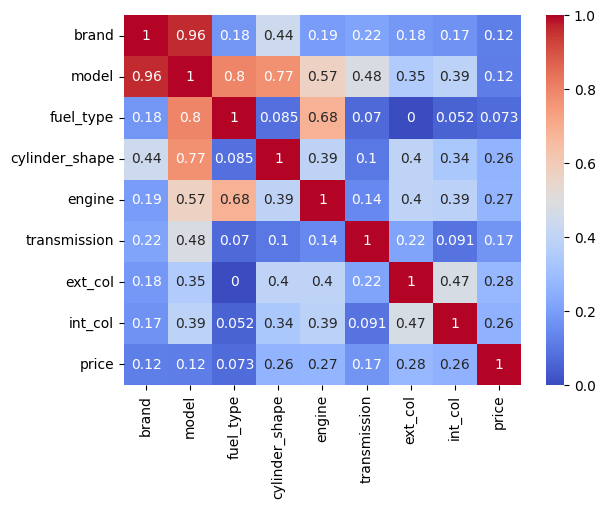

In [105]:
sns.heatmap(chi_corr_matrix, annot=True, cmap='coolwarm')
plt.show()